## Results

### Face Detection Information

In [8]:
total_analyzed_frames = 875887

import sqlite3
import pandas as pd

interaction_conn = sqlite3.connect('/home/nele_pauline_suffo/outputs/quantex_inference/interaction_inference.db')

# Calculate mutually exclusive frame counts to avoid double counting
print("\nMutually Exclusive Frame Categories:")
print("=" * 50)

frame_categories_query = """
WITH UniqueFrames AS (
    -- First group by frame to get unique frame-level face detection info
    SELECT 
        frame_number,
        video_id,
        MAX(CASE WHEN age_class = 0 THEN 1 ELSE 0 END) as has_child_face,
        MAX(CASE WHEN age_class = 1 THEN 1 ELSE 0 END) as has_adult_face
    FROM FaceDetections 
    GROUP BY frame_number, video_id
),
FrameCategories AS (
    -- Categorize each unique frame into mutually exclusive categories
    SELECT 
        frame_number,
        video_id,
        CASE 
            WHEN has_child_face = 1 AND has_adult_face = 1 THEN 'both_faces'
            WHEN has_child_face = 1 AND has_adult_face = 0 THEN 'only_child'
            WHEN has_child_face = 0 AND has_adult_face = 1 THEN 'only_adult'
            ELSE 'no_faces'  -- This shouldn't happen since FaceDetections only has detected faces
        END as frame_category
    FROM UniqueFrames
)
SELECT 
    COUNT(CASE WHEN frame_category = 'only_child' THEN 1 END) AS only_child_face,
    COUNT(CASE WHEN frame_category = 'only_adult' THEN 1 END) AS only_adult_face,
    COUNT(CASE WHEN frame_category = 'both_faces' THEN 1 END) AS both_faces,
    COUNT(DISTINCT frame_number || '_' || video_id) as total_frames_with_faces
FROM FrameCategories
"""

frame_categories = pd.read_sql(frame_categories_query, interaction_conn)

# Calculate the numbers
only_child = frame_categories['only_child_face'].iloc[0]
only_adult = frame_categories['only_adult_face'].iloc[0] 
both_faces = frame_categories['both_faces'].iloc[0]
total_frames_with_faces = frame_categories['total_frames_with_faces'].iloc[0]
no_faces = total_analyzed_frames - total_frames_with_faces

print(f"Frames with ONLY child faces: {only_child:,} ({only_child / total_analyzed_frames * 100:.2f}%)")
print(f"Frames with ONLY adult faces: {only_adult:,} ({only_adult / total_analyzed_frames * 100:.2f}%)")  
print(f"Frames with BOTH face types: {both_faces:,} ({both_faces / total_analyzed_frames * 100:.2f}%)")
print(f"Frames with NO faces: {no_faces:,} ({no_faces / total_analyzed_frames * 100:.2f}%)")

# Verification
total_categorized = only_child + only_adult + both_faces + no_faces
print(f"\nVerification - Total categorized: {total_categorized:,} (should equal {total_analyzed_frames:,})")
print(f"Difference: {abs(total_categorized - total_analyzed_frames):,}")

# Additional statistics
print(f"\nDetailed Face Detection Statistics:")
print(f"Total unique frames with face detections: {total_frames_with_faces:,}")
print(f"Frames with any face detection: {total_frames_with_faces / total_analyzed_frames * 100:.2f}%")

# Close connection
interaction_conn.close()


Mutually Exclusive Frame Categories:
Frames with ONLY child faces: 80,846 (9.23%)
Frames with ONLY adult faces: 66,720 (7.62%)
Frames with BOTH face types: 24,117 (2.75%)
Frames with NO faces: 704,204 (80.40%)

Verification - Total categorized: 875,887 (should equal 875,887)
Difference: 0

Detailed Face Detection Statistics:
Total unique frames with face detections: 171,683
Frames with any face detection: 19.60%
Frames with ONLY child faces: 80,846 (9.23%)
Frames with ONLY adult faces: 66,720 (7.62%)
Frames with BOTH face types: 24,117 (2.75%)
Frames with NO faces: 704,204 (80.40%)

Verification - Total categorized: 875,887 (should equal 875,887)
Difference: 0

Detailed Face Detection Statistics:
Total unique frames with face detections: 171,683
Frames with any face detection: 19.60%


### Person Classification

In [2]:
total_analyzed_frames = 875887

import sqlite3
import pandas as pd

interaction_conn = sqlite3.connect('/home/nele_pauline_suffo/outputs/quantex_inference/interaction_inference.db')

# Calculate mutually exclusive frame counts to avoid double counting
print("\nMutually Exclusive Frame Categories:")
print("=" * 50)

frame_categories_query = """
WITH FrameCategories AS (
    -- Categorize each unique frame into mutually exclusive categories
    SELECT 
        frame_number,
        video_id,
        CASE 
            WHEN has_child_person = 1 AND has_adult_person = 1 THEN 'both_persons'
            WHEN has_child_person = 1 AND has_adult_person = 0 THEN 'only_child'
            WHEN has_child_person = 0 AND has_adult_person = 1 THEN 'only_adult'
            WHEN has_child_person = 0 AND has_adult_person = 0 THEN 'no_persons'
        END as frame_category
    FROM PersonClassifications
)
SELECT 
    COUNT(CASE WHEN frame_category = 'only_child' THEN 1 END) AS only_child_person,
    COUNT(CASE WHEN frame_category = 'only_adult' THEN 1 END) AS only_adult_person,
    COUNT(CASE WHEN frame_category = 'both_persons' THEN 1 END) AS both_persons,
    COUNT(CASE WHEN frame_category = 'no_persons' THEN 1 END) AS no_persons
FROM FrameCategories
"""

frame_categories = pd.read_sql(frame_categories_query, interaction_conn)

# Calculate the numbers
only_child = frame_categories['only_child_person'].iloc[0]
only_adult = frame_categories['only_adult_person'].iloc[0] 
both_persons = frame_categories['both_persons'].iloc[0]
no_persons = frame_categories['no_persons'].iloc[0]
total_categorized = only_child + only_adult + both_persons + no_persons
total_frames_with_persons = only_child + only_adult + both_persons

print(f"Frames with ONLY child persons: {only_child:,} ({only_child / total_categorized * 100:.2f}%)")
print(f"Frames with ONLY adult persons: {only_adult:,} ({only_adult / total_categorized * 100:.2f}%)")
print(f"Frames with BOTH person types: {both_persons:,} ({both_persons / total_categorized * 100:.2f}%)")
print(f"Frames with NO persons: {no_persons:,} ({no_persons / total_categorized * 100:.2f}%)")

# Verification
print(f"\nVerification - Total categorized: {total_categorized:,}")

# Additional statistics
print(f"\nDetailed Person Detection Statistics:")
print(f"Total unique frames with person detections: {total_frames_with_persons:,}")
print(f"Frames with any person detection: {total_frames_with_persons / total_categorized * 100:.2f}%")

# Close connection
interaction_conn.close()


Mutually Exclusive Frame Categories:
Frames with ONLY child persons: 2,279 (0.26%)
Frames with ONLY adult persons: 9,590 (1.09%)
Frames with BOTH person types: 1,031 (0.12%)
Frames with NO persons: 862,987 (98.53%)

Verification - Total categorized: 875,887

Detailed Person Detection Statistics:
Total unique frames with person detections: 12,900
Frames with any person detection: 1.47%
Frames with ONLY child persons: 2,279 (0.26%)
Frames with ONLY adult persons: 9,590 (1.09%)
Frames with BOTH person types: 1,031 (0.12%)
Frames with NO persons: 862,987 (98.53%)

Verification - Total categorized: 875,887

Detailed Person Detection Statistics:
Total unique frames with person detections: 12,900
Frames with any person detection: 1.47%


### Combined Face and Person Presence Analysis

In [3]:
import sqlite3
import pandas as pd

interaction_conn = sqlite3.connect(
    '/home/nele_pauline_suffo/outputs/quantex_inference/interaction_inference.db'
)

# Step 1: Pre-aggregate face detections
interaction_conn.execute("""
CREATE TEMP TABLE IF NOT EXISTS FaceAgg AS
SELECT 
    frame_number,
    video_id,
    MAX(CASE WHEN age_class = 0 THEN 1 ELSE 0 END) AS has_child_face,
    MAX(CASE WHEN age_class = 1 THEN 1 ELSE 0 END) AS has_adult_face
FROM FaceDetections
GROUP BY frame_number, video_id;
""")

# Step 2 & 3: Combine with person detections and aggregate
combined_results = pd.read_sql("""
SELECT
    SUM(CASE WHEN child_present = 1 AND adult_present = 0 THEN 1 ELSE 0 END) AS only_child_present,
    SUM(CASE WHEN child_present = 0 AND adult_present = 1 THEN 1 ELSE 0 END) AS only_adult_present,
    SUM(CASE WHEN child_present = 1 AND adult_present = 1 THEN 1 ELSE 0 END) AS both_present,
    SUM(CASE WHEN child_present = 0 AND adult_present = 0 THEN 1 ELSE 0 END) AS no_one_present,
    COUNT(*) AS total_frames_analyzed
FROM (
    SELECT
        pd.frame_number,
        pd.video_id,
        COALESCE(fa.has_child_face, 0) AS has_child_face,
        COALESCE(fa.has_adult_face, 0) AS has_adult_face,
        pd.has_child_person,
        pd.has_adult_person,
        CASE WHEN COALESCE(fa.has_child_face,0)=1 OR pd.has_child_person=1 THEN 1 ELSE 0 END AS child_present,
        CASE WHEN COALESCE(fa.has_adult_face,0)=1 OR pd.has_adult_person=1 THEN 1 ELSE 0 END AS adult_present
    FROM PersonClassifications pd
    LEFT JOIN FaceAgg fa
    ON pd.frame_number = fa.frame_number AND pd.video_id = fa.video_id
)
""", interaction_conn)

# Extract results
only_child = combined_results['only_child_present'].iloc[0]
only_adult = combined_results['only_adult_present'].iloc[0]
both_present = combined_results['both_present'].iloc[0]
no_one_present = combined_results['no_one_present'].iloc[0]
total_frames_analyzed = combined_results['total_frames_analyzed'].iloc[0]

print(f"Frames with ONLY child present: {only_child:,} ({only_child / total_analyzed_frames * 100:.2f}%)")
print(f"Frames with ONLY adult present: {only_adult:,} ({only_adult / total_analyzed_frames * 100:.2f}%)")
print(f"Frames with BOTH present: {both_present:,} ({both_present / total_frames_analyzed * 100:.2f}%)")
print(f"Frames with NO ONE present: {no_one_present:,} ({no_one_present / total_frames_analyzed * 100:.2f}%)")

# Verification
total_categorized = only_child + only_adult + both_present + no_one_present
print(f"\nVerification:")
print(f"Total frames categorized: {total_categorized:,}")
print(f"Total frames analyzed: {total_frames_analyzed:,}")

# Additional insights
any_presence = only_child + only_adult + both_present
print(f"\nSummary Insights:")
print(f"Frames with ANY human presence: {any_presence:,} ({any_presence / total_frames_analyzed * 100:.2f}%)")
print(f"Frames with child presence: {only_child + both_present:,} ({(only_child + both_present) / total_frames_analyzed * 100:.2f}%)")
print(f"Frames with adult presence: {only_adult + both_present:,} ({(only_adult + both_present) / total_frames_analyzed * 100:.2f}%)")

interaction_conn.close()

Frames with ONLY child present: 81,819 (9.34%)
Frames with ONLY adult present: 73,470 (8.39%)
Frames with BOTH present: 25,973 (2.97%)
Frames with NO ONE present: 694,625 (79.31%)

Verification:
Total frames categorized: 875,887
Total frames analyzed: 875,887
Coverage: 100.00%

Summary Insights:
Frames with ANY human presence: 181,262 (20.69%)
Frames with child presence: 107,792 (12.31%)
Frames with adult presence: 99,443 (11.35%)


In [1]:
import sqlite3
import pandas as pd

total_analyzed_frames = 875_887

interaction_conn = sqlite3.connect(
    '/home/nele_pauline_suffo/outputs/quantex_inference/interaction_inference.db'
)

# Step 1: Pre-aggregate face detections
interaction_conn.execute("""
CREATE TEMP TABLE IF NOT EXISTS FaceAgg AS
SELECT 
    frame_number,
    video_id,
    MAX(CASE WHEN age_class = 0 THEN 1 ELSE 0 END) AS has_child_face,
    MAX(CASE WHEN age_class = 1 THEN 1 ELSE 0 END) AS has_adult_face
FROM FaceDetections
GROUP BY frame_number, video_id;
""")

# Step 2: Combine with person detections and include video age_group from the Videos table
combined_results = pd.read_sql("""
SELECT
    age_group,
    only_child_present,
    only_adult_present,
    both_present,
    no_one_present,
    total_frames_analyzed,
    ROUND(only_child_present * 100.0 / total_frames_analyzed, 2) AS pct_only_child,
    ROUND(only_adult_present * 100.0 / total_frames_analyzed, 2) AS pct_only_adult,
    ROUND(both_present * 100.0 / total_frames_analyzed, 2) AS pct_both,
    ROUND(no_one_present * 100.0 / total_frames_analyzed, 2) AS pct_none
FROM (
    SELECT
        age_group,
        SUM(CASE WHEN child_present = 1 AND adult_present = 0 THEN 1 ELSE 0 END) AS only_child_present,
        SUM(CASE WHEN child_present = 0 AND adult_present = 1 THEN 1 ELSE 0 END) AS only_adult_present,
        SUM(CASE WHEN child_present = 1 AND adult_present = 1 THEN 1 ELSE 0 END) AS both_present,
        SUM(CASE WHEN child_present = 0 AND adult_present = 0 THEN 1 ELSE 0 END) AS no_one_present,
        COUNT(*) AS total_frames_analyzed
    FROM (
        SELECT
            pd.frame_number,
            pd.video_id,
            v.age_group AS age_group,
            COALESCE(fa.has_child_face, 0) AS has_child_face,
            COALESCE(fa.has_adult_face, 0) AS has_adult_face,
            pd.has_child_person,
            pd.has_adult_person,
            CASE WHEN COALESCE(fa.has_child_face,0)=1 OR pd.has_child_person=1 THEN 1 ELSE 0 END AS child_present,
            CASE WHEN COALESCE(fa.has_adult_face,0)=1 OR pd.has_adult_person=1 THEN 1 ELSE 0 END AS adult_present
        FROM PersonClassifications pd
        LEFT JOIN FaceAgg fa
            ON pd.frame_number = fa.frame_number AND pd.video_id = fa.video_id
        LEFT JOIN Videos v
            ON pd.video_id = v.video_id
    )
    GROUP BY age_group
) 
ORDER BY age_group;
""", interaction_conn)

interaction_conn.close()

# Print results per age_group
for idx, row in combined_results.iterrows():
    age_group = row['age_group']
    only_child = row['only_child_present']
    only_adult = row['only_adult_present']
    both_present = row['both_present']
    no_one_present = row['no_one_present']
    total_frames = row['total_frames_analyzed']

    print(f"\nAge group: {age_group}")
    print(f"Frames with ONLY child present: {only_child} ({only_child / total_frames * 100:.2f}%)")
    print(f"Frames with ONLY adult present: {only_adult} ({only_adult / total_frames * 100:.2f}%)")
    print(f"Frames with BOTH present: {both_present} ({both_present / total_frames * 100:.2f}%)")
    print(f"Frames with NO ONE present: {no_one_present} ({no_one_present / total_frames * 100:.2f}%)")
    print(f"Total frames analyzed: {total_frames}")


Age group: 3.0
Frames with ONLY child present: 9189.0 (8.11%)
Frames with ONLY adult present: 8493.0 (7.50%)
Frames with BOTH present: 3773.0 (3.33%)
Frames with NO ONE present: 91814.0 (81.06%)
Total frames analyzed: 113269.0

Age group: 4.0
Frames with ONLY child present: 35274.0 (9.53%)
Frames with ONLY adult present: 32295.0 (8.73%)
Frames with BOTH present: 10891.0 (2.94%)
Frames with NO ONE present: 291644.0 (78.80%)
Total frames analyzed: 370104.0

Age group: 5.0
Frames with ONLY child present: 37356.0 (9.52%)
Frames with ONLY adult present: 32682.0 (8.33%)
Frames with BOTH present: 11309.0 (2.88%)
Frames with NO ONE present: 311167.0 (79.28%)
Total frames analyzed: 392514.0


In [2]:
import sqlite3
import pandas as pd

# Connect to the database
interaction_conn = sqlite3.connect(
    '/home/nele_pauline_suffo/outputs/quantex_inference/interaction_inference.db'
)

# Step 1: Pre-aggregate face detections
interaction_conn.execute("""
CREATE TEMP TABLE IF NOT EXISTS FaceAgg AS
SELECT 
    frame_number,
    video_id,
    MAX(CASE WHEN age_class = 0 THEN 1 ELSE 0 END) AS has_child_face,
    MAX(CASE WHEN age_class = 1 THEN 1 ELSE 0 END) AS has_adult_face
FROM FaceDetections
GROUP BY frame_number, video_id;
""")

# Step 2: Combine with person detections and include exact age_at_recording
combined_results = pd.read_sql("""
SELECT
    age_at_recording,
    SUM(CASE WHEN child_present = 1 AND adult_present = 0 THEN 1 ELSE 0 END) AS only_child_present,
    SUM(CASE WHEN child_present = 0 AND adult_present = 1 THEN 1 ELSE 0 END) AS only_adult_present,
    SUM(CASE WHEN child_present = 1 AND adult_present = 1 THEN 1 ELSE 0 END) AS both_present,
    SUM(CASE WHEN child_present = 0 AND adult_present = 0 THEN 1 ELSE 0 END) AS no_one_present,
    COUNT(*) AS total_frames
FROM (
    SELECT
        pd.frame_number,
        pd.video_id,
        v.age_at_recording,
        COALESCE(fa.has_child_face, 0) AS has_child_face,
        COALESCE(fa.has_adult_face, 0) AS has_adult_face,
        pd.has_child_person,
        pd.has_adult_person,
        CASE WHEN COALESCE(fa.has_child_face,0)=1 OR pd.has_child_person=1 THEN 1 ELSE 0 END AS child_present,
        CASE WHEN COALESCE(fa.has_adult_face,0)=1 OR pd.has_adult_person=1 THEN 1 ELSE 0 END AS adult_present
    FROM PersonClassifications pd
    LEFT JOIN FaceAgg fa
        ON pd.frame_number = fa.frame_number AND pd.video_id = fa.video_id
    LEFT JOIN Videos v
        ON pd.video_id = v.video_id
)
GROUP BY age_at_recording
ORDER BY age_at_recording;
""", interaction_conn)

interaction_conn.close()

# Step 3: Calculate percentages relative to total frames per age
combined_results['pct_only_child'] = combined_results['only_child_present'] / combined_results['total_frames'] * 100
combined_results['pct_only_adult'] = combined_results['only_adult_present'] / combined_results['total_frames'] * 100
combined_results['pct_both'] = combined_results['both_present'] / combined_results['total_frames'] * 100
combined_results['pct_none'] = combined_results['no_one_present'] / combined_results['total_frames'] * 100

# Print results (optional)
for idx, row in combined_results.iterrows():
    print(f"\nAge at recording: {row['age_at_recording']}")
    print(f"Frames with ONLY child present: {row['only_child_present']} ({row['pct_only_child']:.2f}%)")
    print(f"Frames with ONLY adult present: {row['only_adult_present']} ({row['pct_only_adult']:.2f}%)")
    print(f"Frames with BOTH present: {row['both_present']} ({row['pct_both']:.2f}%)")
    print(f"Frames with NO ONE present: {row['no_one_present']} ({row['pct_none']:.2f}%)")
    print(f"Total frames analyzed: {row['total_frames']}")

# Step 4: DataFrame ready for plotting
plot_df = combined_results[['age_at_recording', 'pct_only_child', 'pct_only_adult', 'pct_both', 'pct_none']]
print("\nData ready for plotting:")
print(plot_df.head())


Age at recording: 2.8
Frames with ONLY child present: 194.0 (3.76%)
Frames with ONLY adult present: 967.0 (18.72%)
Frames with BOTH present: 208.0 (4.03%)
Frames with NO ONE present: 3797.0 (73.50%)
Total frames analyzed: 5166.0

Age at recording: 3.2
Frames with ONLY child present: 150.0 (3.85%)
Frames with ONLY adult present: 558.0 (14.32%)
Frames with BOTH present: 141.0 (3.62%)
Frames with NO ONE present: 3047.0 (78.21%)
Total frames analyzed: 3896.0

Age at recording: 3.47
Frames with ONLY child present: 211.0 (2.25%)
Frames with ONLY adult present: 445.0 (4.74%)
Frames with BOTH present: 70.0 (0.75%)
Frames with NO ONE present: 8667.0 (92.27%)
Total frames analyzed: 9393.0

Age at recording: 3.68
Frames with ONLY child present: 728.0 (7.00%)
Frames with ONLY adult present: 1344.0 (12.93%)
Frames with BOTH present: 1080.0 (10.39%)
Frames with NO ONE present: 7245.0 (69.68%)
Total frames analyzed: 10397.0

Age at recording: 3.69
Frames with ONLY child present: 325.0 (6.26%)
Frames

In [3]:
import sqlite3
import pandas as pd
import numpy as np

# Conversion constants
FPS = 30
ROUND_TO = 10

db_path = '/home/nele_pauline_suffo/outputs/quantex_inference/interaction_inference.db'
conn = sqlite3.connect(db_path)

# Load Person & Face data
person_df = pd.read_sql("""
    SELECT
        p.video_id,
        p.frame_number,
        CASE WHEN p.has_child_person=1 OR f_c.age_class=0 THEN 1 ELSE 0 END AS child_present,
        CASE WHEN p.has_adult_person=1 OR f_a.age_class=1 THEN 1 ELSE 0 END AS adult_present
    FROM PersonClassifications p
    LEFT JOIN (SELECT video_id, frame_number, age_class FROM FaceDetections WHERE age_class = 0) f_c
        ON p.video_id = f_c.video_id AND p.frame_number = f_c.frame_number
    LEFT JOIN (SELECT video_id, frame_number, age_class FROM FaceDetections WHERE age_class = 1) f_a
        ON p.video_id = f_a.video_id AND p.frame_number = f_a.frame_number
    ORDER BY p.video_id, p.frame_number;
""", conn)

# Load Vocalizations separately
vocal_df = pd.read_sql("""
    SELECT video_id, start_time_seconds, end_time_seconds, speaker
    FROM Vocalizations;
""", conn)

conn.close()

# Round helper
def round_to_nearest(x, base=ROUND_TO):
    return int(base * round(float(x) / base))

# Convert vocalization intervals to frame ranges
vocal_df['start_frame'] = vocal_df['start_time_seconds'].apply(lambda t: round_to_nearest(t * FPS))
vocal_df['end_frame'] = vocal_df['end_time_seconds'].apply(lambda t: round_to_nearest(t * FPS))

# Expand to frame-level mapping
speech_rows = []
for _, row in vocal_df.iterrows():
    for frame in range(row['start_frame'], row['end_frame'] + ROUND_TO, ROUND_TO):
        speech_rows.append((row['video_id'], frame, row['speaker']))

speech_df = pd.DataFrame(speech_rows, columns=['video_id', 'frame_number', 'speaker'])

# Merge speech info into main DataFrame
df = person_df.merge(speech_df, on=['video_id', 'frame_number'], how='left')

# Create flags
df['kchi_speech_present'] = (df['speaker'] == 'KCHI').astype(int)
df['other_speech_present'] = (df['speaker'] == 'OTH').astype(int)

# Mark "not alone" (any adult, child, or speech)
df['not_alone_detection'] = (df['adult_present'] == 1) | (df['child_present'] == 1) | (df['speaker'].notna())

print(df.head())

   video_id  frame_number  child_present  adult_present speaker  \
0         1             0              0              1     OTH   
1         1            10              0              1     OTH   
2         1            20              1              1     OTH   
3         1            20              1              1     OTH   
4         1            20              1              1     OTH   

   kchi_speech_present  other_speech_present  not_alone_detection  
0                    0                     1                 True  
1                    0                     1                 True  
2                    0                     1                 True  
3                    0                     1                 True  
4                    0                     1                 True  


In [16]:
df.to_parquet("/home/nele_pauline_suffo/outputs/quantex_inference/df_time_alone.parquet", engine="fastparquet")

In [19]:
import pandas as pd
import numpy as np

# Example: fps = 30 frames/sec, but we only sample every 10th frame
fps = 30
sample_rate = 10  # every 10th frame
window_sec = 30
window_size_frames = window_sec * fps  # full window size
window_size_sampled = window_size_frames // sample_rate  # number of sampled frames per window
threshold = window_size_sampled * 0.1  # at least 10% of frames (e.g., 9/90)

# df is your dataframe with columns:
# ['video_id', 'frame_number', 'not_alone_detection']

all_merged_segments = []

for video_id, video_df in df.groupby('video_id'):
    video_df = video_df.sort_values('frame_number').reset_index(drop=True)
    frame_numbers = video_df['frame_number'].values
    not_alone = video_df['not_alone_detection'].values
    
    segments = []
    
    # Sliding window
    for start_idx in range(0, len(frame_numbers) - window_size_sampled + 1, 1):  # stride=1
        window_frames = not_alone[start_idx:start_idx + window_size_sampled]
        if np.sum(window_frames) >= threshold:
            start_frame = frame_numbers[start_idx]
            end_frame = frame_numbers[start_idx + window_size_sampled - 1]
            segments.append([video_id, start_frame, end_frame])
    
    if not segments:
        continue
    
    segments = pd.DataFrame(segments, columns=['video_id', 'start_frame', 'end_frame'])
    
    # --------------------------
    # Merge overlapping / nearby segments
    # --------------------------
    merged_segments = []
    for vid, group in segments.groupby('video_id'):
        group = group.sort_values('start_frame').reset_index(drop=True)
        current_start = group.iloc[0]['start_frame']
        current_end = group.iloc[0]['end_frame']
        
        for i in range(1, len(group)):
            row = group.iloc[i]
            # Merge if start <= current_end + 2 sec gap
            if row['start_frame'] <= current_end + 2 * fps:
                current_end = max(current_end, row['end_frame'])
            else:
                merged_segments.append([vid, current_start, current_end])
                current_start = row['start_frame']
                current_end = row['end_frame']
        
        merged_segments.append([vid, current_start, current_end])
    
    all_merged_segments.extend(merged_segments)

# Convert to dataframe
merged_df = pd.DataFrame(all_merged_segments, columns=['video_id', 'start_frame', 'end_frame'])

# Convert to seconds
merged_df['start_time_sec'] = merged_df['start_frame'] / fps
merged_df['end_time_sec'] = merged_df['end_frame'] / fps

In [26]:
# get video_name from database and add it as second column to the dataframe
interaction_conn = sqlite3.connect('/home/nele_pauline_suffo/outputs/quantex_inference/interaction_inference.db')
video_names = pd.read_sql("SELECT video_id, video_name FROM Videos", interaction_conn)
interaction_conn.close()

# Merge video names into the main dataframe
merged_df = merged_df.merge(video_names, on='video_id', how='left')

In [ ]:
# rearranve the columns
merged_df = merged_df[['video_id', 'video_name', 'start_frame', 'end_frame', 'start_time_sec', 'end_time_sec']]

In [30]:
merged_df[merged_df['video_id'] == 1]

,video_id,video_name,start_frame,end_frame,start_time_sec,end_time_sec
0,1,quantex_at_home_id254922_2022_04_12_01,0,35160,0.0,1172.0


In [ ]:
frames_with_detections_query = """
WITH FramesWithDetections AS (
    -- First get unique frames with detections for each class and video
    SELECT
        v.id,
        v.video_id,
        d.frame_number,
        MAX(CASE WHEN d.object_class = 1.0 THEN 1 ELSE 0 END) as has_adult,
        MAX(CASE WHEN d.object_class = 0.0 THEN 1 ELSE 0 END) as has_child,
        MAX(CASE WHEN d.object_class = 3.0 THEN 1 ELSE 0 END) as has_adult_face,
        MAX(CASE WHEN d.object_class = 2.0 THEN 1 ELSE 0 END) as has_child_face,
        MAX(CASE WHEN d.object_class = 5.0 THEN 1 ELSE 0 END) as has_book,
        MAX(CASE WHEN d.object_class = 6.0 THEN 1 ELSE 0 END) as has_toy,
        MAX(CASE WHEN d.object_class = 7.0 THEN 1 ELSE 0 END) as has_kitchenware,
        MAX(CASE WHEN d.object_class = 8.0 THEN 1 ELSE 0 END) as has_screen,
        MAX(CASE WHEN d.object_class = 9.0 THEN 1 ELSE 0 END) as has_food,
        MAX(CASE WHEN d.object_class = 10.0 THEN 1 ELSE 0 END) as has_other_object
    FROM Videos v
    JOIN Detections d ON v.video_id = d.video_id
    WHERE v.video_id NOT IN (116, 13, 120, 45, 99, 427, 321, 387)
    GROUP BY v.id, v.video_id, d.frame_number
),
TotalFramesPerChild AS (
    -- Calculate total frames per child ID
    SELECT 
        v.id,
        SUM(vs.total_frames) as total_frames
    FROM Videos v
    JOIN VideoStatistics vs ON v.video_id = vs.video_id
    WHERE v.video_id NOT IN (116, 13, 120, 45, 99, 427, 321, 387)
    GROUP BY v.id
)
-- Then aggregate detections by child ID
SELECT 
    f.id,
    COUNT(DISTINCT f.video_id) as video_count,
    t.total_frames,
    SUM(f.has_adult) as frames_with_adult,
    SUM(f.has_child) as frames_with_child,
    SUM(f.has_adult_face) as frames_with_adult_face,
    SUM(f.has_child_face) as frames_with_child_face,
    SUM(f.has_book) as frames_with_book,
    SUM(f.has_toy) as frames_with_toy,
    SUM(f.has_kitchenware) as frames_with_kitchenware,
    SUM(f.has_screen) as frames_with_screen,
    SUM(f.has_food) as frames_with_food,
    SUM(f.has_other_object) as frames_with_other_object
FROM FramesWithDetections f
JOIN TotalFramesPerChild t ON f.id = t.id
JOIN VideoStatistics vs ON f.video_id = vs.video_id
WHERE vs.video_id NOT IN (116, 13, 120, 45, 99, 427, 321, 387)
GROUP BY f.id, t.total_frames
ORDER BY f.id;
"""

# Execute query and create DataFrame
frames_with_detections = pd.read_sql(frames_with_detections_query, conn)


# Calculate percentages
for col in frames_with_detections.columns[3:]:  # Skip id, video_count, and total_frames
    frames_with_detections[f'{col}_percent'] = (
        frames_with_detections[col] / frames_with_detections['total_frames'] * 100
    ).round(2)

# Display results
display(frames_with_detections)

,id,video_count,total_frames,frames_with_adult,frames_with_child,frames_with_adult_face,frames_with_child_face,frames_with_book,frames_with_toy,frames_with_kitchenware,...,frames_with_adult_percent,frames_with_child_percent,frames_with_adult_face_percent,frames_with_child_face_percent,frames_with_book_percent,frames_with_toy_percent,frames_with_kitchenware_percent,frames_with_screen_percent,frames_with_food_percent,frames_with_other_object_percent
0,254922,5,201729,4095,2756,2682,1479,688,1373,97,...,2.03,1.37,1.33,0.73,0.34,0.68,0.05,0.01,0.01,0.75
1,255237,6,282993,5405,15208,1570,6359,1165,7373,50,...,1.91,5.37,0.55,2.25,0.41,2.61,0.02,0.02,0.12,1.05
2,255695,4,68763,2165,2357,780,1008,5,881,630,...,3.15,3.43,1.13,1.47,0.01,1.28,0.92,0.00,0.00,0.47
3,255706,2,72922,3693,2122,1178,1359,379,1557,458,...,5.06,2.91,1.62,1.86,0.52,2.14,0.63,0.00,0.00,0.25
4,255944,5,138006,3224,4767,849,2661,2067,1244,244,...,2.34,3.45,0.62,1.93,1.50,0.90,0.18,0.00,0.03,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,271611,7,286457,2972,2895,2210,232,1005,3994,471,...,1.04,1.01,0.77,0.08,0.35,1.39,0.16,0.01,0.06,0.96
70,271700,6,200637,9361,2115,5093,1233,736,1244,130,...,4.67,1.05,2.54,0.61,0.37,0.62,0.06,0.02,0.04,1.06
71,272475,4,171070,5154,1768,1888,868,1211,676,169,...,3.01,1.03,1.10,0.51,0.71,0.40,0.10,0.01,0.02,1.17
72,273855,6,303755,6960,1994,2302,656,588,1060,74,...,2.29,0.66,0.76,0.22,0.19,0.35,0.02,0.01,0.01,0.47


In [23]:
# load csv into dataframe
df = pd.read_csv('/home/nele_pauline_suffo/outputs/detection_pipeline_results/frames_with_detections.csv')
# add column processed_frames as total_frames / 10 and round up (show without decimals)
df['processed_frames'] = np.ceil(df['total_frames'] / 10).astype(int)

# make column processed_frames appear after total_frames
cols = df.columns.tolist()
cols.insert(3, cols.pop(cols.index('processed_frames')))
df = df.reindex(columns=cols)

# calculate percentage of frames with adults and all other classes, show percentage with two decimals
df['frames_with_adult_percent'] = (df['frames_with_adult'] / df['processed_frames'] * 100).round(2)
df['frames_with_child_percent'] = (df['frames_with_child'] / df['processed_frames'] * 100).round(2)
df['frames_with_adult_face_percent'] = (df['frames_with_adult_face'] / df['processed_frames'] * 100).round(2)
df['frames_with_child_face_percent'] = (df['frames_with_child_face'] / df['processed_frames'] * 100).round(2)
df['frames_with_book_percent'] = (df['frames_with_book'] / df['processed_frames'] * 100).round(2)
df['frames_with_toy_percent'] = (df['frames_with_toy'] / df['processed_frames'] * 100).round(2)
df['frames_with_kitchenware_percent'] = (df['frames_with_kitchenware'] / df['processed_frames'] * 100).round(2)
df['frames_with_screen_percent'] = (df['frames_with_screen'] / df['processed_frames'] * 100).round(2)
df['frames_with_food_percent'] = (df['frames_with_food'] / df['processed_frames'] * 100).round(2)
df['frames_with_other_object_percent'] = (df['frames_with_other_object'] / df['processed_frames'] * 100).round(2)

# calculate video_length from total_frames, video is taken at 30 fps
# divide by 30 then by 60 to get minutes
df['video_length_min'] = (df['total_frames'] / 30 / 60).round(2)
cols = df.columns.tolist()
cols.insert(3, cols.pop(cols.index('video_length_min')))
frames_with_detections_new = df.reindex(columns=cols)
frames_with_detections_new

,id,video_count,total_frames,video_length_min,processed_frames,video_length,frames_with_adult,frames_with_child,frames_with_adult_face,frames_with_child_face,...,frames_with_adult_percent,frames_with_child_percent,frames_with_adult_face_percent,frames_with_child_face_percent,frames_with_book_percent,frames_with_toy_percent,frames_with_kitchenware_percent,frames_with_screen_percent,frames_with_food_percent,frames_with_other_object_percent
0,254922,5,201729,112.07,20173,112.07,4095,2756,2682,1479,...,20.30,13.66,13.29,7.33,3.41,6.81,0.48,0.07,0.09,7.53
1,255237,6,282993,157.22,28300,157.22,5405,15208,1570,6359,...,19.10,53.74,5.55,22.47,4.12,26.05,0.18,0.19,1.18,10.46
2,255695,4,68763,38.20,6877,38.20,2165,2357,780,1008,...,31.48,34.27,11.34,14.66,0.07,12.81,9.16,0.01,0.00,4.74
3,255706,2,72922,40.51,7293,40.51,3693,2122,1178,1359,...,50.64,29.10,16.15,18.63,5.20,21.35,6.28,0.03,0.04,2.54
4,255944,5,138006,76.67,13801,76.67,3224,4767,849,2661,...,23.36,34.54,6.15,19.28,14.98,9.01,1.77,0.01,0.27,9.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,271611,7,286457,159.14,28646,159.14,2972,2895,2210,232,...,10.37,10.11,7.71,0.81,3.51,13.94,1.64,0.07,0.55,9.62
70,271700,6,200637,111.46,20064,111.46,9361,2115,5093,1233,...,46.66,10.54,25.38,6.15,3.67,6.20,0.65,0.19,0.44,10.62
71,272475,4,171070,95.04,17107,95.04,5154,1768,1888,868,...,30.13,10.33,11.04,5.07,7.08,3.95,0.99,0.15,0.15,11.70
72,273855,6,303755,168.75,30376,168.75,6960,1994,2302,656,...,22.91,6.56,7.58,2.16,1.94,3.49,0.24,0.11,0.07,4.72


In [24]:
# save frames_with_detections to csv
frames_with_detections_new.to_csv('/home/nele_pauline_suffo/outputs/detection_pipeline_results/frames_with_detections.csv', index=False)

#### Get adult presence vs. child presence over different age groups 

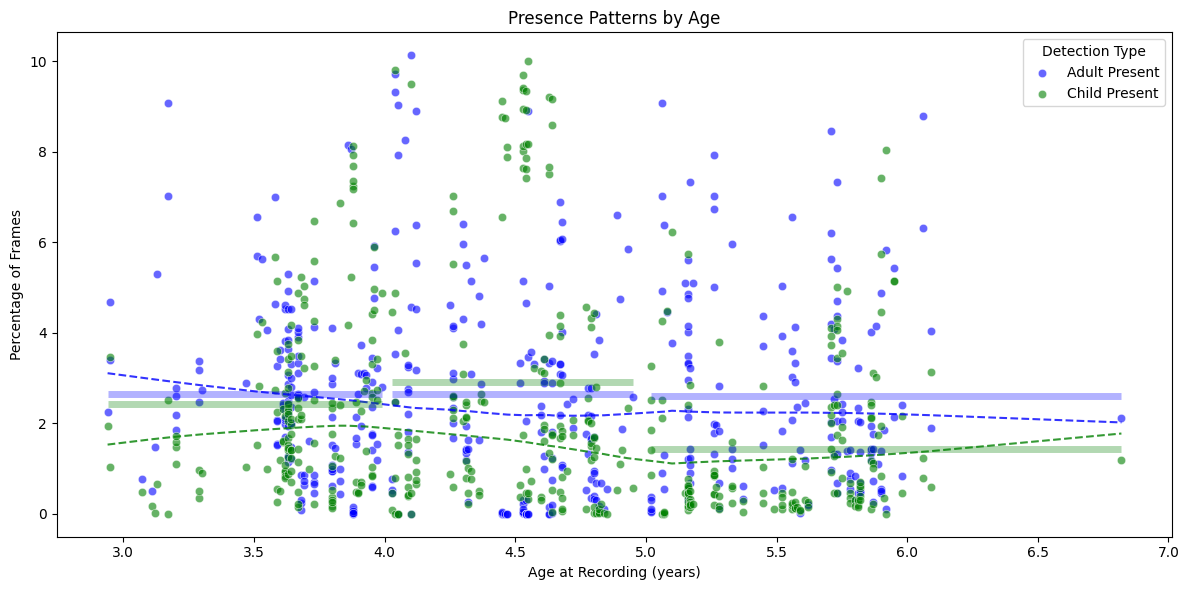


Summary Statistics by Age Group:

Age Group 3 (age range: 2.94-3.99):
Adult Present: 2.64% (±1.77)
Child Present: 2.42% (±1.91)
Number of videos: 143

Age Group 4 (age range: 4.03-4.95):
Adult Present: 2.64% (±2.41)
Child Present: 2.90% (±3.01)
Number of videos: 153

Age Group 5 (age range: 5.02-6.82):
Adult Present: 2.61% (±2.14)
Child Present: 1.43% (±1.67)
Number of videos: 148


In [4]:
presence_query = """
WITH UniqueFrames AS (
    SELECT 
        v.id as child_id,
        v.age_at_recording,
        v.video_id,
        d.frame_number,
        MAX(CASE WHEN d.object_class IN (1.0, 3.0) THEN 1 ELSE 0 END) as has_adult,
        MAX(CASE WHEN d.object_class IN (0.0, 2.0) THEN 1 ELSE 0 END) as has_child
    FROM Videos v
    JOIN Detections d ON v.video_id = d.video_id
    WHERE v.age_at_recording IS NOT NULL 
    AND v.video_id NOT IN (116, 13, 120, 45, 99, 427, 321, 387)
    GROUP BY v.id, v.age_at_recording, v.video_id, d.frame_number
),
FrameCounts AS (
    SELECT 
        UniqueFrames.child_id,
        UniqueFrames.age_at_recording,
        UniqueFrames.video_id,
        v2.total_frames,
        COUNT(DISTINCT frame_number) as frames_with_detections,
        SUM(has_adult) as frames_with_adult,
        SUM(has_child) as frames_with_child
    FROM UniqueFrames
    JOIN VideoStatistics v2 ON UniqueFrames.video_id = v2.video_id
    GROUP BY UniqueFrames.child_id, UniqueFrames.age_at_recording, UniqueFrames.video_id, v2.total_frames
)
SELECT 
    child_id,
    age_at_recording,
    video_id,
    SUM(total_frames) as total_frames,
    SUM(frames_with_adult) as frames_with_adult,
    SUM(frames_with_child) as frames_with_child,
    ROUND(SUM(frames_with_adult) * 100.0 / SUM(total_frames), 2) as adult_percent,
    ROUND(SUM(frames_with_child) * 100.0 / SUM(total_frames), 2) as child_percent
FROM FrameCounts
GROUP BY child_id, age_at_recording, video_id
ORDER BY age_at_recording;
"""

# Execute query and create DataFrame
presence_data = pd.read_sql(presence_query, conn)

# Add age groups
def assign_age_group(age):
    if age < 4:
        return 3
    elif age < 5:
        return 4
    else:
        return 5

presence_data['age_group'] = presence_data['age_at_recording'].apply(assign_age_group)

# Create visualization
plt.figure(figsize=(12, 6))

# Plot adult and child percentages
sns.scatterplot(data=presence_data, 
                x='age_at_recording', 
                y='adult_percent',
                color='blue',
                alpha=0.6,
                label='Adult Present')

sns.scatterplot(data=presence_data, 
                x='age_at_recording', 
                y='child_percent',
                color='green',
                alpha=0.6,
                label='Child Present')

# Add LOWESS smoothing instead of linear regression
from statsmodels.nonparametric.smoothers_lowess import lowess

# LOWESS for adult percentage
adult_smooth = lowess(presence_data['adult_percent'], 
                     presence_data['age_at_recording'],
                     frac=0.6)
plt.plot(adult_smooth[:, 0], adult_smooth[:, 1], 
         color='blue', linestyle='--', alpha=0.8)

# LOWESS for child percentage
child_smooth = lowess(presence_data['child_percent'], 
                     presence_data['age_at_recording'],
                     frac=0.6)
plt.plot(child_smooth[:, 0], child_smooth[:, 1], 
         color='green', linestyle='--', alpha=0.8)

# Add mean lines for age groups
for age_group in sorted(presence_data['age_group'].unique()):
    group_data = presence_data[presence_data['age_group'] == age_group]
    
    # Adult means
    adult_mean = group_data['adult_percent'].mean()
    age_min = group_data['age_at_recording'].min()
    age_max = group_data['age_at_recording'].max()
    plt.hlines(y=adult_mean, xmin=age_min, xmax=age_max, 
               colors='blue', linestyles='-', alpha=0.3, linewidth=5)
    
    # Child means
    child_mean = group_data['child_percent'].mean()
    plt.hlines(y=child_mean, xmin=age_min, xmax=age_max, 
               colors='green', linestyles='-', alpha=0.3, linewidth=5)

plt.title('Presence Patterns by Age')
plt.xlabel('Age at Recording (years)')
plt.ylabel('Percentage of Frames')
plt.legend(title='Detection Type')

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/presence_patterns_lowess.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print statistical summary
print("\nSummary Statistics by Age Group:")
for age in sorted(presence_data['age_group'].unique()):
    age_data = presence_data[presence_data['age_group'] == age]
    print(f"\nAge Group {age} (age range: {age_data['age_at_recording'].min():.2f}-{age_data['age_at_recording'].max():.2f}):")
    print(f"Adult Present: {age_data['adult_percent'].mean():.2f}% (±{age_data['adult_percent'].std():.2f})")
    print(f"Child Present: {age_data['child_percent'].mean():.2f}% (±{age_data['child_percent'].std():.2f})")
    print(f"Number of videos: {len(age_data)}")

#### Number of frames with one adult/child, two adults/children etc

In [ ]:
presence_count_query = """
WITH FaceOverlaps AS (
    SELECT 
        d1.video_id,
        d1.frame_number,
        d1.detection_id,
        d1.object_class,
        CASE 
            WHEN d1.object_class IN (2.0, 3.0) THEN 1
            ELSE 2
        END as detection_priority,
        CASE WHEN EXISTS (
            SELECT 1 FROM Detections d2
            WHERE d2.video_id = d1.video_id
            AND d2.frame_number = d1.frame_number
            AND d2.object_class = d1.object_class
            AND d2.detection_id < d1.detection_id
            AND d2.video_id NOT IN (116, 13, 120, 45, 99, 427, 321, 387)
            -- Calculate intersection area
            AND (CASE 
                WHEN d1.x_min > d2.x_max OR d2.x_min > d1.x_max OR
                     d1.y_min > d2.y_max OR d2.y_min > d1.y_max 
                THEN 0
                ELSE (min(d1.x_max, d2.x_max) - max(d1.x_min, d2.x_min)) *
                     (min(d1.y_max, d2.y_max) - max(d1.y_min, d2.y_min))
                END) /
            -- Calculate union area
            ((d1.x_max - d1.x_min) * (d1.y_max - d1.y_min) +
             (d2.x_max - d2.x_min) * (d2.y_max - d2.y_min) -
             (CASE 
                WHEN d1.x_min > d2.x_max OR d2.x_min > d1.x_max OR
                     d1.y_min > d2.y_max OR d2.y_min > d1.y_max 
                THEN 0
                ELSE (min(d1.x_max, d2.x_max) - max(d1.x_min, d2.x_min)) *
                     (min(d1.y_max, d2.y_max) - max(d1.y_min, d2.y_min))
                END)) > 0.5
        ) THEN 1 ELSE 0 END as is_duplicate
    FROM Detections d1
    WHERE d1.object_class IN (0.0, 1.0, 2.0, 3.0)
    AND d1.video_id NOT IN (116, 13, 120, 45, 99, 427, 321, 387)
),
FrameCounts AS (
    -- Count unique detections per frame
    SELECT 
        v.id as child_id,
        v.age_at_recording,
        v.video_id,
        f.frame_number,
        -- Count unique adults (prioritize faces over bodies)
        COUNT(DISTINCT CASE 
            WHEN (f.object_class IN (3.0) OR (f.object_class = 1.0 AND NOT EXISTS (
                SELECT 1 FROM FaceOverlaps f2 
                WHERE f2.video_id = f.video_id 
                AND f2.frame_number = f.frame_number 
                AND f2.object_class = 3.0
            )))
            AND f.is_duplicate = 0 THEN f.detection_id 
        END) as adult_count,
        -- Count unique children (prioritize faces over bodies)
        COUNT(DISTINCT CASE 
            WHEN (f.object_class IN (2.0) OR (f.object_class = 0.0 AND NOT EXISTS (
                SELECT 1 FROM FaceOverlaps f2 
                WHERE f2.video_id = f.video_id 
                AND f2.frame_number = f.frame_number 
                AND f2.object_class = 2.0
            )))
            AND f.is_duplicate = 0 THEN f.detection_id 
        END) as child_count
    FROM Videos v
    JOIN FaceOverlaps f ON v.video_id = f.video_id
    WHERE v.age_at_recording IS NOT NULL
    AND v.video_id NOT IN (116, 13, 120, 45, 99, 427, 321, 387)
    GROUP BY v.id, v.age_at_recording, v.video_id, f.frame_number
)
SELECT 
    child_id,
    age_at_recording,
    video_id,
    COUNT(DISTINCT frame_number) as total_frames,
    -- Adult counts
    SUM(CASE WHEN adult_count >= 1 THEN 1 ELSE 0 END) as frames_with_one_plus_adult,
    SUM(CASE WHEN adult_count >= 2 THEN 1 ELSE 0 END) as frames_with_two_plus_adult,
    SUM(CASE WHEN adult_count >= 3 THEN 1 ELSE 0 END) as frames_with_three_plus_adult,
    -- Child counts
    SUM(CASE WHEN child_count >= 1 THEN 1 ELSE 0 END) as frames_with_one_plus_child,
    SUM(CASE WHEN child_count >= 2 THEN 1 ELSE 0 END) as frames_with_two_plus_child,
    SUM(CASE WHEN child_count >= 3 THEN 1 ELSE 0 END) as frames_with_three_plus_child,
    -- Percentages
    ROUND(SUM(CASE WHEN adult_count >= 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as one_plus_adult_percent,
    ROUND(SUM(CASE WHEN adult_count >= 2 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as two_plus_adult_percent,
    ROUND(SUM(CASE WHEN adult_count >= 3 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as three_plus_adult_percent,
    ROUND(SUM(CASE WHEN child_count >= 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as one_plus_child_percent,
    ROUND(SUM(CASE WHEN child_count >= 2 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as two_plus_child_percent,
    ROUND(SUM(CASE WHEN child_count >= 3 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as three_plus_child_percent
FROM FrameCounts
GROUP BY child_id, age_at_recording, video_id
ORDER BY age_at_recording;
"""
presence_count_data = pd.read_sql(presence_count_query, conn)

def assign_age_group(age):
    if age < 4:
        return 3
    elif age < 5:
        return 4
    else:
        return 5

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Add age groups
presence_count_data['age_group'] = presence_count_data['age_at_recording'].apply(assign_age_group)

# Plot adults
colors_adult = {'one_plus': 'darkblue', 'two_plus': 'blue', 'three_plus': 'lightblue'}
for count_type, color in colors_adult.items():
    col = f'{count_type}_adult_percent'
    sns.scatterplot(data=presence_count_data, 
                    x='age_at_recording',
                    y=col,
                    color=color,
                    alpha=0.6,
                    label=f'{count_type.replace("_", " ").title()} Adults',
                    ax=ax1)
    
    # Add LOWESS trend
    smooth = lowess(presence_count_data[col], 
                   presence_count_data['age_at_recording'],
                   frac=0.6)
    ax1.plot(smooth[:, 0], smooth[:, 1], 
             color=color, linestyle='--', alpha=0.8)
    
    # Add mean lines for each age group
    for age_group in [3, 4, 5]:
        group_data = presence_count_data[presence_count_data['age_group'] == age_group]
        mean_val = group_data[col].mean()
        ax1.hlines(y=mean_val,
                  xmin=group_data['age_at_recording'].min(),
                  xmax=group_data['age_at_recording'].max(),
                  colors=color,
                  alpha=0.3,
                  linewidth=5)

ax1.set_title('Adult Presence Patterns')
ax1.set_xlabel('Age at Recording (years)')
ax1.set_ylabel('Percentage of Frames')

# Plot children
colors_child = {'one_plus': 'darkgreen', 'two_plus': 'green', 'three_plus': 'lightgreen'}
for count_type, color in colors_child.items():
    col = f'{count_type}_child_percent'
    sns.scatterplot(data=presence_count_data,
                    x='age_at_recording',
                    y=col,
                    color=color,
                    alpha=0.6,
                    label=f'{count_type.replace("_", " ").title()} Children',
                    ax=ax2)
    
    # Add LOWESS trend
    smooth = lowess(presence_count_data[col],
                   presence_count_data['age_at_recording'],
                   frac=0.6)
    ax2.plot(smooth[:, 0], smooth[:, 1],
             color=color, linestyle='--', alpha=0.8)
    
    # Add mean lines for each age group
    for age_group in [3, 4, 5]:
        group_data = presence_count_data[presence_count_data['age_group'] == age_group]
        mean_val = group_data[col].mean()
        ax2.hlines(y=mean_val,
                  xmin=group_data['age_at_recording'].min(),
                  xmax=group_data['age_at_recording'].max(),
                  colors=color,
                  alpha=0.3,
                  linewidth=5)

ax2.set_title('Child Presence Patterns')
ax2.set_xlabel('Age at Recording (years)')
ax2.set_ylabel('Percentage of Frames')

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/presence_count_patterns.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics by age group
summary_stats = presence_count_data.groupby('age_group').agg({
    'one_plus_adult_percent': ['mean', 'std', 'count'],
    'two_plus_adult_percent': ['mean', 'std', 'count'],
    'three_plus_adult_percent': ['mean', 'std', 'count'],
    'one_plus_child_percent': ['mean', 'std', 'count'],
    'two_plus_child_percent': ['mean', 'std', 'count'],
    'three_plus_child_percent': ['mean', 'std', 'count']
}).round(2)

print("\nPresence Count Summary by Age Group:")
print(summary_stats)

In [2]:
presence_count_data

NameError: name 'presence_count_data' is not defined

#### Compare percentage of adult faces looking at child vs. child faces looking at child

In [1]:
gaze_analysis_query = """
SELECT 
    v.id as id,
    v.age_at_recording,
    v.video_id,
    -- Adult gaze counts
    COUNT(CASE WHEN d.object_class = 3.0 THEN 1 END) as total_adult_faces,
    COUNT(CASE WHEN d.object_class = 3.0 AND d.gaze_direction = 1 THEN 1 END) as adult_gazing,
    -- Child gaze counts
    COUNT(CASE WHEN d.object_class = 2.0 THEN 1 END) as total_child_faces,
    COUNT(CASE WHEN d.object_class = 2.0 AND d.gaze_direction = 1 THEN 1 END) as child_gazing,
    -- Calculate percentages
    ROUND(COUNT(CASE WHEN d.object_class = 3.0 AND d.gaze_direction = 1.0 THEN 1 END) * 100.0 / 
          NULLIF(COUNT(CASE WHEN d.object_class = 3.0 THEN 1 END), 0), 2) as adult_gaze_percent,
    ROUND(COUNT(CASE WHEN d.object_class = 2.0 AND d.gaze_direction = 1 THEN 1 END) * 100.0 / 
          NULLIF(COUNT(CASE WHEN d.object_class = 2.0 THEN 1 END), 0), 2) as child_gaze_percent
FROM Videos v
JOIN Detections d ON v.video_id = d.video_id
WHERE v.age_at_recording IS NOT NULL
    AND d.object_class IN (2.0, 3.0)  -- Only look at face detections
GROUP BY v.id, v.age_at_recording, v.video_id
ORDER BY v.age_at_recording;
"""
# Execute query and create DataFrame
gaze_patterns = pd.read_sql(gaze_analysis_query, conn)

# Create age groups for statistics (but keep original age_at_recording for plotting)
def assign_age_group(age):
    if age < 4:
        return 3
    elif age < 5:
        return 4
    else:
        return 5

# Add age group column but keep original age_at_recording for plotting
gaze_patterns['age_group'] = gaze_patterns['age_at_recording'].apply(assign_age_group)

# Create figure
plt.figure(figsize=(12, 6))

# Plot adult gaze percentages
sns.scatterplot(data=gaze_patterns, 
                x='age_at_recording', 
                y='adult_gaze_percent',
                color='blue',
                alpha=0.6,
                label='Adult Faces')

# Plot child gaze percentages
sns.scatterplot(data=gaze_patterns, 
                x='age_at_recording', 
                y='child_gaze_percent',
                color='green',
                alpha=0.6,
                label='Child Faces')

# Add trend lines with confidence intervals
sns.regplot(data=gaze_patterns,
            x='age_at_recording',
            y='adult_gaze_percent',
            scatter=False,
            color='blue',
            line_kws={'linestyle': '--'})

sns.regplot(data=gaze_patterns,
            x='age_at_recording',
            y='child_gaze_percent',
            scatter=False,
            color='green',
            line_kws={'linestyle': '--'})

# Add mean lines for age groups
for age_group in sorted(gaze_patterns['age_group'].unique()):
    group_data = gaze_patterns[gaze_patterns['age_group'] == age_group]
    
    # Adult means
    adult_mean = group_data['adult_gaze_percent'].mean()
    age_min = group_data['age_at_recording'].min()
    age_max = group_data['age_at_recording'].max()
    plt.hlines(y=adult_mean, xmin=age_min, xmax=age_max, 
               colors='blue', linestyles='-', alpha=0.3, linewidth=5)
    
    # Child means
    child_mean = group_data['child_gaze_percent'].mean()
    plt.hlines(y=child_mean, xmin=age_min, xmax=age_max, 
               colors='green', linestyles='-', alpha=0.3, linewidth=5)

plt.title('Gaze Patterns by Age')
plt.xlabel('Age at Recording (years)')
plt.ylabel('Percentage of Faces with Gaze')
plt.legend(title='Face Type')

# Set y-axis limits to focus on main data range
plt.ylim(0, min(100, gaze_patterns[['adult_gaze_percent', 'child_gaze_percent']].max().max() * 1.1))

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/gaze_patterns_continuous.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print statistical summary
print("\nSummary Statistics by Age Group:")
for age in sorted(gaze_patterns['age_group'].unique()):
    age_data = gaze_patterns[gaze_patterns['age_group'] == age]
    print(f"\nAge Group {age} (age range: {age_data['age_at_recording'].min():.2f}-{age_data['age_at_recording'].max():.2f}):")
    print(f"Adult Gaze: {age_data['adult_gaze_percent'].mean():.2f}% (±{age_data['adult_gaze_percent'].std():.2f})")
    print(f"Child Gaze: {age_data['child_gaze_percent'].mean():.2f}% (±{age_data['child_gaze_percent'].std():.2f})")
    print(f"Number of videos: {len(age_data)}")

NameError: name 'pd' is not defined

#### Analyse proximity value across age groups and adults vs children

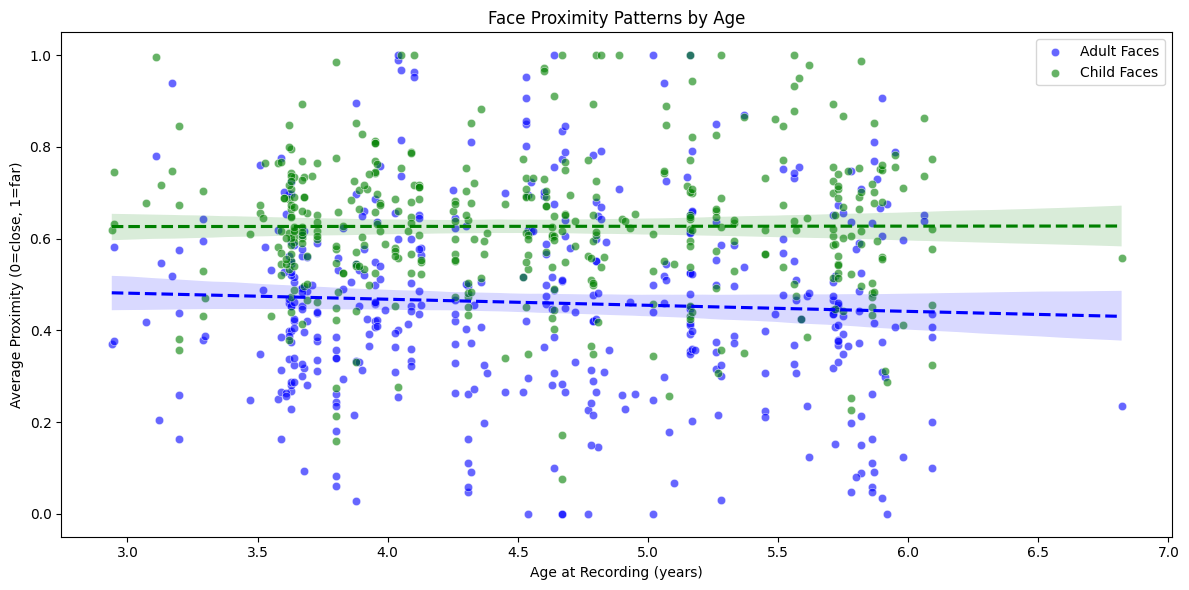


Proximity Pattern Comparison:

Overall Proximity:
Adult mean proximity: 0.451
Child mean proximity: 0.628
t-statistic: -18.662
p-value: 0.0000
Number of valid comparisons: 401


In [ ]:
# Query to get proximity data with float values
proximity_query = """
SELECT 
    v.id as id,
    v.age_at_recording,
    v.video_id,
    -- Adult faces (object_class 3)
    COUNT(CASE WHEN d.object_class = 3.0 THEN 1 END) as total_adult_faces,
    AVG(CASE WHEN d.object_class = 3.0 THEN d.proximity END) as avg_adult_proximity,
    -- Child faces (object_class 2)
    COUNT(CASE WHEN d.object_class = 2.0 THEN 1 END) as total_child_faces,
    AVG(CASE WHEN d.object_class = 2.0 THEN d.proximity END) as avg_child_proximity
FROM Videos v
JOIN Detections d ON v.video_id = d.video_id
WHERE v.age_at_recording IS NOT NULL
    AND d.object_class IN (2.0, 3.0)
    AND d.proximity IS NOT NULL
GROUP BY v.id, v.age_at_recording, v.video_id
"""

# Execute query and create DataFrame
proximity_patterns = pd.read_sql(proximity_query, conn)

# Create visualization
plt.figure(figsize=(12, 6))

# Plot proximity values (0 = close, 1 = far)
sns.scatterplot(data=proximity_patterns, 
                x='age_at_recording', 
                y='avg_adult_proximity',
                color='blue',
                alpha=0.6,
                label='Adult Faces')

sns.scatterplot(data=proximity_patterns, 
                x='age_at_recording', 
                y='avg_child_proximity',
                color='green',
                alpha=0.6,
                label='Child Faces')

# Add trend lines
sns.regplot(data=proximity_patterns,
            x='age_at_recording',
            y='avg_adult_proximity',
            scatter=False,
            color='blue',
            line_kws={'linestyle': '--'})

sns.regplot(data=proximity_patterns,
            x='age_at_recording',
            y='avg_child_proximity',
            scatter=False,
            color='green',
            line_kws={'linestyle': '--'})

plt.title('Face Proximity Patterns by Age')
plt.xlabel('Age at Recording (years)')
plt.ylabel('Average Proximity (0=close, 1=far)')
plt.legend()

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/proximity_patterns_by_age.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Statistical comparison between adult and child proximity
print("\nProximity Pattern Comparison:")
valid_data = proximity_patterns.dropna(subset=['avg_adult_proximity', 'avg_child_proximity'])
if len(valid_data) > 1:
    t_stat, p_value = stats.ttest_rel(
        valid_data['avg_adult_proximity'],
        valid_data['avg_child_proximity']
    )
    print(f"\nOverall Proximity:")
    print(f"Adult mean proximity: {valid_data['avg_adult_proximity'].mean():.3f}")
    print(f"Child mean proximity: {valid_data['avg_child_proximity'].mean():.3f}")
    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Number of valid comparisons: {len(valid_data)}")

#### Analyse connection between proximity and gaze relationship

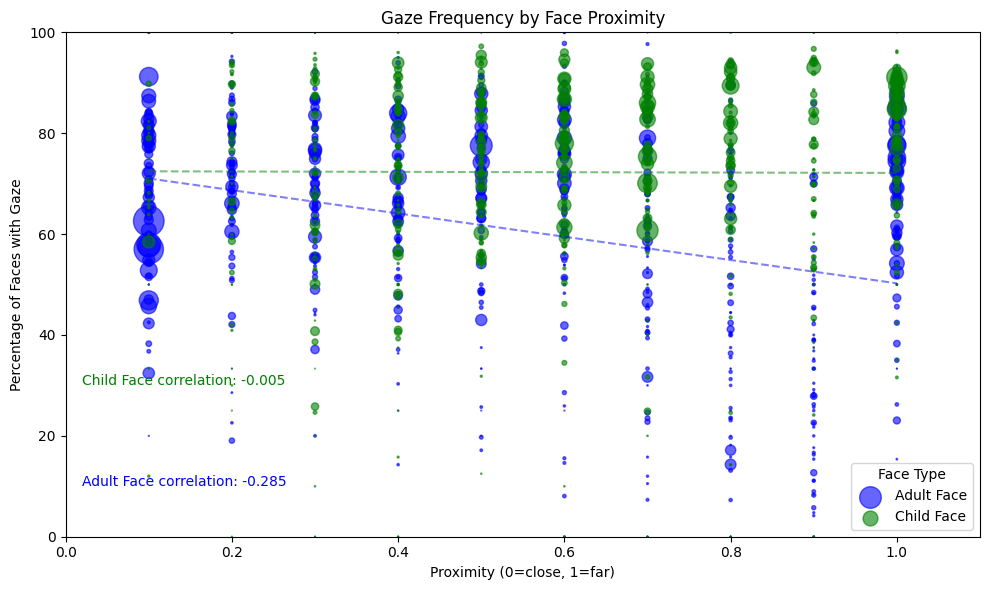


Statistical Analysis of Proximity vs Gaze Relationship:

Adult Face:
Correlation coefficient: -0.285
P-value: 0.0000
Average gaze percentage for close faces (proximity < 0.3): 68.34%
Average gaze percentage for far faces (proximity > 0.7): 49.45%

Child Face:
Correlation coefficient: -0.005
P-value: 0.9073
Average gaze percentage for close faces (proximity < 0.3): 76.44%
Average gaze percentage for far faces (proximity > 0.7): 73.00%


In [ ]:
# Query to analyze proximity vs gaze relationship
proximity_gaze_query = """
SELECT 
    v.id as id,
    d.object_class,
    -- Create bins (0-0.1, 0.1-0.2, etc.)
    CASE 
        WHEN d.proximity <= 0.1 THEN 0.1
        WHEN d.proximity <= 0.2 THEN 0.2
        WHEN d.proximity <= 0.3 THEN 0.3
        WHEN d.proximity <= 0.4 THEN 0.4
        WHEN d.proximity <= 0.5 THEN 0.5
        WHEN d.proximity <= 0.6 THEN 0.6
        WHEN d.proximity <= 0.7 THEN 0.7
        WHEN d.proximity <= 0.8 THEN 0.8
        WHEN d.proximity <= 0.9 THEN 0.9
        ELSE 1.0
    END as proximity_bin,
    COUNT(*) as total_faces,
    SUM(CASE WHEN d.gaze_direction = 1 THEN 1 ELSE 0 END) as faces_with_gaze,
    ROUND(SUM(CASE WHEN d.gaze_direction = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as gaze_percent
FROM Videos v
JOIN Detections d ON v.video_id = d.video_id
WHERE d.object_class IN (2.0, 3.0)
    AND d.proximity IS NOT NULL
    AND d.gaze_direction IS NOT NULL
GROUP BY v.id, d.object_class, proximity_bin
ORDER BY d.object_class, proximity_bin;
"""

# Execute query and create DataFrame
prox_gaze_patterns = pd.read_sql(proximity_gaze_query, conn)

prox_gaze_patterns['object_class'] = prox_gaze_patterns['object_class'].astype(float)
prox_gaze_patterns['face_type'] = prox_gaze_patterns['object_class'].apply(lambda x: 'Child Face' if x == 2.0 else 'Adult Face' if x == 3.0 else None)

# Create single figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for each face type
colors = {'Adult Face': 'blue', 'Child Face': 'green'}
for face_type in ['Adult Face', 'Child Face']:
    face_data = prox_gaze_patterns[prox_gaze_patterns['face_type'] == face_type]
    
    if len(face_data) >= 2:
        # Adjust size scaling - divide total_faces by 10 for smaller points
        scatter = ax.scatter(face_data['proximity_bin'],
                           face_data['gaze_percent'],
                           s=face_data['total_faces']/10,  # Reduced size scaling
                           alpha=0.6,
                           c=colors[face_type],
                           label=face_type)
        
        # Add trend line
        z = np.polyfit(face_data['proximity_bin'], face_data['gaze_percent'], 1)
        p = np.poly1d(z)
        ax.plot(face_data['proximity_bin'], 
                p(face_data['proximity_bin']), 
                '--', 
                color=colors[face_type],
                alpha=0.5)
        
        # Add correlation in lower left corner
        corr = face_data['proximity_bin'].corr(face_data['gaze_percent'])
        y_pos = 10 + (20 * (['Adult Face', 'Child Face'].index(face_type)))
        plt.text(0.02, y_pos,
                f'{face_type} correlation: {corr:.3f}',
                color=colors[face_type])

plt.title('Gaze Frequency by Face Proximity')
plt.xlabel('Proximity (0=close, 1=far)')
plt.ylabel('Percentage of Faces with Gaze')
plt.legend(title='Face Type')

# Set axis limits
plt.xlim(0, 1.1)
plt.ylim(0, 100)

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/proximity_vs_gaze.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Statistical analysis with data validation
print("\nStatistical Analysis of Proximity vs Gaze Relationship:")
for face_type in ['Adult Face', 'Child Face']:
    face_data = prox_gaze_patterns[prox_gaze_patterns['face_type'] == face_type]
    
    if len(face_data) >= 2:
        # Correlation test
        correlation, p_value = stats.pearsonr(face_data['proximity_bin'], face_data['gaze_percent'])
        
        print(f"\n{face_type}:")
        print(f"Correlation coefficient: {correlation:.3f}")
        print(f"P-value: {p_value:.4f}")
        
        # Calculate averages only if we have data in those ranges
        close_faces = face_data[face_data['proximity_bin'] < 0.3]
        far_faces = face_data[face_data['proximity_bin'] > 0.7]
        
        if len(close_faces) > 0:
            print(f"Average gaze percentage for close faces (proximity < 0.3): "
                  f"{close_faces['gaze_percent'].mean():.2f}%")
        if len(far_faces) > 0:
            print(f"Average gaze percentage for far faces (proximity > 0.7): "
                  f"{far_faces['gaze_percent'].mean():.2f}%")
    else:
        print(f"\n{face_type}: Insufficient data for analysis")


#### Combined object and adult vs. object and child detection

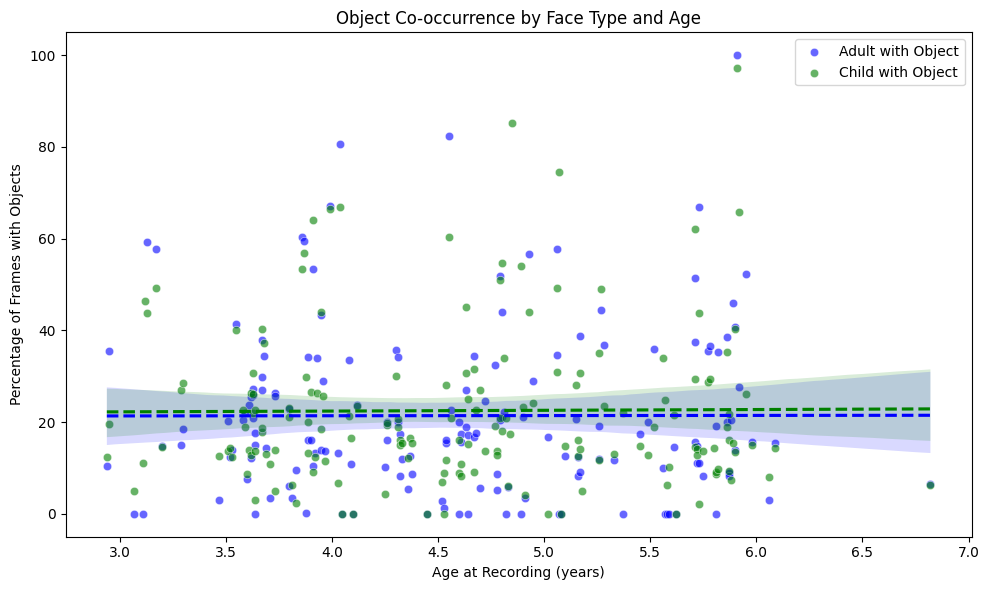


Statistical Comparison:
Adult with object mean: 21.40%
Child with object mean: 22.24%
t-statistic: -0.847
p-value: 0.3981
Number of valid comparisons: 162


In [3]:
object_cooccurrence_query = """
WITH FrameObjects AS (
    SELECT 
        v.id as id,
        v.age_at_recording,
        v.video_id,
        d.frame_number,
        MAX(CASE WHEN d.object_class = 2.0 THEN 1 ELSE 0 END) as has_adult_face,
        MAX(CASE WHEN d.object_class IN (5.0, 6.0, 7.0, 8.0, 9.0, 10.0) THEN 1 ELSE 0 END) as has_object,
        MAX(CASE WHEN d.object_class = 3.0 THEN 1 ELSE 0 END) as has_child_face
    FROM Videos v
    JOIN Detections d ON v.video_id = d.video_id
    WHERE v.video_id NOT IN (116, 13, 120, 45, 99, 427, 321, 387)
    GROUP BY v.id, v.age_at_recording, v.video_id, d.frame_number
)
SELECT 
    id,
    age_at_recording,
    COUNT(DISTINCT frame_number) as total_frames,
    SUM(has_adult_face) as frames_with_adult,
    SUM(has_child_face) as frames_with_child,
    SUM(CASE WHEN has_adult_face = 1 AND has_object = 1 THEN 1 ELSE 0 END) as adult_object_frames,
    SUM(CASE WHEN has_child_face = 1 AND has_object = 1 THEN 1 ELSE 0 END) as child_object_frames,
    -- Calculate percentages based on frames where faces are present
    ROUND(SUM(CASE WHEN has_adult_face = 1 AND has_object = 1 THEN 1 ELSE 0 END) * 100.0 / 
          NULLIF(SUM(has_adult_face), 0), 2) as adult_object_percent,
    ROUND(SUM(CASE WHEN has_child_face = 1 AND has_object = 1 THEN 1 ELSE 0 END) * 100.0 / 
          NULLIF(SUM(has_child_face), 0), 2) as child_object_percent
FROM FrameObjects
GROUP BY id, age_at_recording
ORDER BY age_at_recording;
"""

# Execute query and create DataFrame
object_patterns = pd.read_sql(object_cooccurrence_query, conn)

# Create visualization
plt.figure(figsize=(10, 6))

# Plot percentages
sns.scatterplot(data=object_patterns, 
                x='age_at_recording', 
                y='adult_object_percent',
                color='blue',
                alpha=0.6,
                label='Adult with Object')

sns.scatterplot(data=object_patterns, 
                x='age_at_recording', 
                y='child_object_percent',
                color='green',
                alpha=0.6,
                label='Child with Object')

# Add trend lines
sns.regplot(data=object_patterns,
            x='age_at_recording',
            y='adult_object_percent',
            scatter=False,
            color='blue',
            line_kws={'linestyle': '--'})

sns.regplot(data=object_patterns,
            x='age_at_recording',
            y='child_object_percent',
            scatter=False,
            color='green',
            line_kws={'linestyle': '--'})

plt.title('Object Co-occurrence by Face Type and Age')
plt.xlabel('Age at Recording (years)')
plt.ylabel('Percentage of Frames with Objects')
plt.legend()

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/object_cooccurrence.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Statistical comparison
valid_data = object_patterns.dropna(subset=['adult_object_percent', 'child_object_percent'])
if len(valid_data) > 1:
    t_stat, p_value = stats.ttest_rel(
        valid_data['adult_object_percent'],
        valid_data['child_object_percent']
    )
    print("\nStatistical Comparison:")
    print(f"Adult with object mean: {valid_data['adult_object_percent'].mean():.2f}%")
    print(f"Child with object mean: {valid_data['child_object_percent'].mean():.2f}%")
    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Number of valid comparisons: {len(valid_data)}")

### Object prevalence

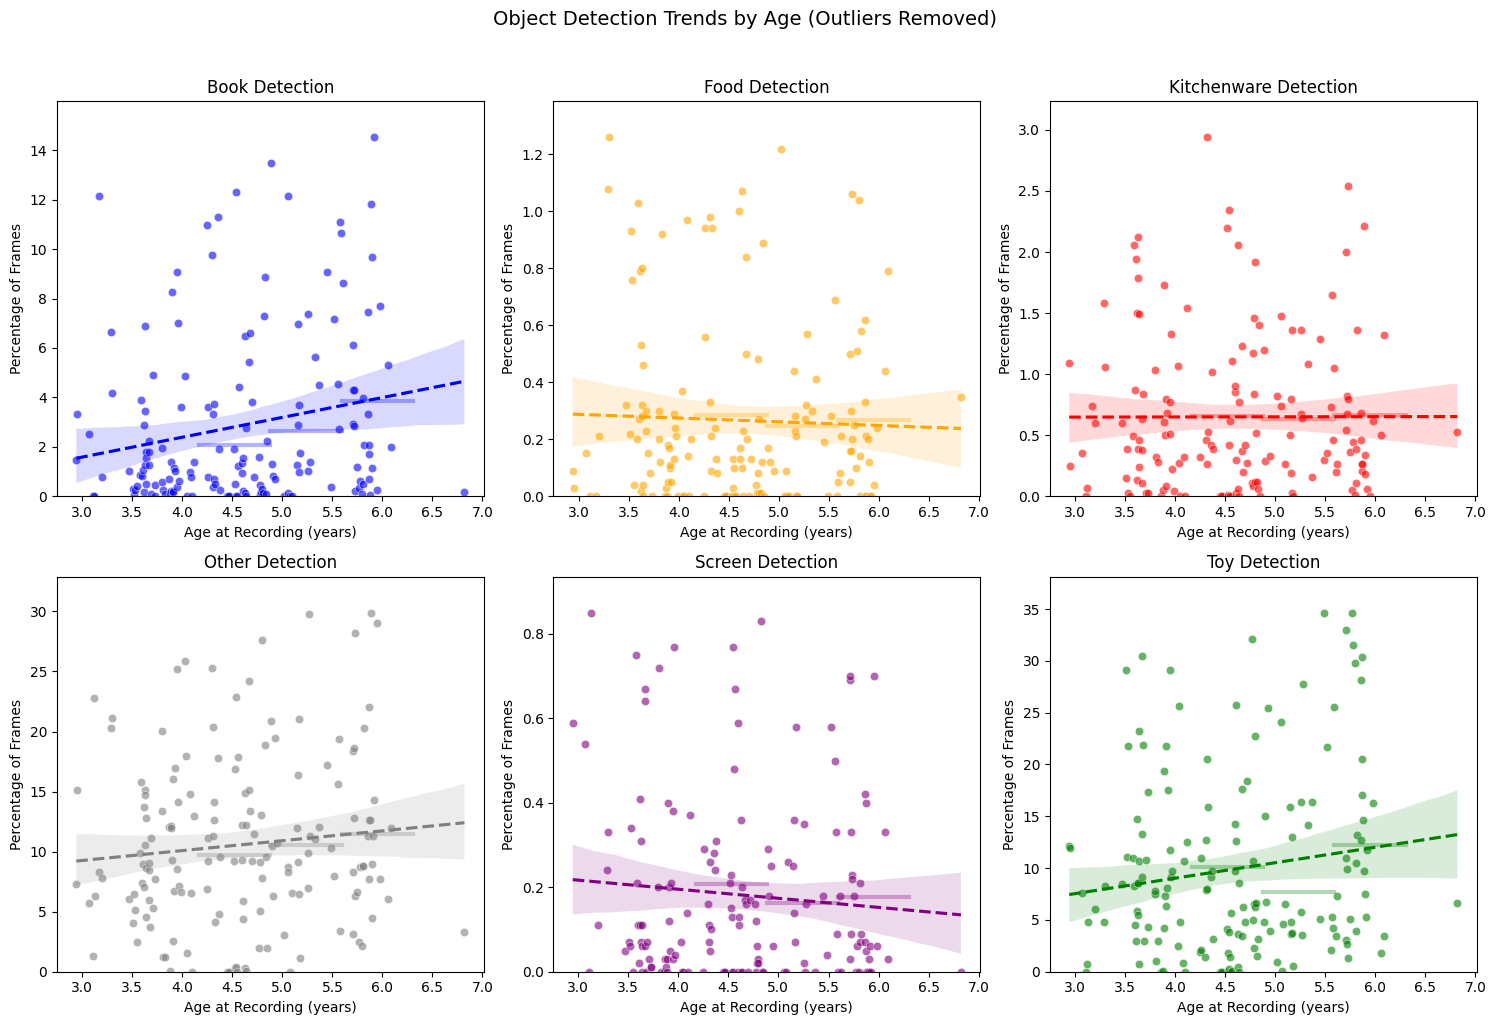


Outliers removed:
book: 15 outliers removed
toy: 10 outliers removed
kitchenware: 20 outliers removed
screen: 17 outliers removed
food: 18 outliers removed
other: 12 outliers removed


In [2]:
object_frequency_query = """
WITH ObjectCounts AS (
    SELECT 
        v.id as id,
        v.age_at_recording,
        v.video_id,
        COUNT(DISTINCT d.frame_number) as total_frames,
        -- Count frames with each object type
        SUM(CASE WHEN d.object_class = 5.0 THEN 1 ELSE 0 END) as book_frames,
        SUM(CASE WHEN d.object_class = 6.0 THEN 1 ELSE 0 END) as toy_frames,
        SUM(CASE WHEN d.object_class = 7.0 THEN 1 ELSE 0 END) as kitchenware_frames,
        SUM(CASE WHEN d.object_class = 8.0 THEN 1 ELSE 0 END) as screen_frames,
        SUM(CASE WHEN d.object_class = 9.0 THEN 1 ELSE 0 END) as food_frames,
        SUM(CASE WHEN d.object_class = 10.0 THEN 1 ELSE 0 END) as other_object_frames
    FROM Videos v
    JOIN Detections d ON v.video_id = d.video_id
    WHERE v.video_id NOT IN (116, 13, 120, 45, 99, 427, 321, 387)
    GROUP BY v.id, v.age_at_recording, v.video_id
)
SELECT 
    id,
    age_at_recording,
    -- Calculate percentages for each object type
    ROUND(SUM(book_frames) * 100.0 / SUM(total_frames), 2) as book_percent,
    ROUND(SUM(toy_frames) * 100.0 / SUM(total_frames), 2) as toy_percent,
    ROUND(SUM(kitchenware_frames) * 100.0 / SUM(total_frames), 2) as kitchenware_percent,
    ROUND(SUM(screen_frames) * 100.0 / SUM(total_frames), 2) as screen_percent,
    ROUND(SUM(food_frames) * 100.0 / SUM(total_frames), 2) as food_percent,
    ROUND(SUM(other_object_frames) * 100.0 / SUM(total_frames), 2) as other_percent
FROM ObjectCounts
GROUP BY id, age_at_recording
ORDER BY age_at_recording;
"""

# Execute query and create DataFrame
object_freq = pd.read_sql(object_frequency_query, conn)

# Define age group assignment function
def assign_age_group(age):
    if age < 4:
        return 3
    elif age < 5:
        return 4
    else:
        return 5

# Execute query and create DataFrame
object_freq = pd.read_sql(object_frequency_query, conn)

# Apply age grouping BEFORE melting
object_freq['age_group'] = object_freq['age_at_recording'].apply(assign_age_group)

# Reshape data for better plotting
object_freq_melted = object_freq.melt(
    id_vars=['age_at_recording', 'age_group'],
    value_vars=['book_percent', 'toy_percent', 'kitchenware_percent', 
                'screen_percent', 'food_percent', 'other_percent'],
    var_name='object_type',
    value_name='percentage'
)

# Clean up object type names
object_freq_melted['object_type'] = object_freq_melted['object_type'].str.replace('_percent', '')
def remove_outliers(group):
    Q1 = group['percentage'].quantile(0.25)
    Q3 = group['percentage'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['percentage'] >= lower_bound) & (group['percentage'] <= upper_bound)]

# Remove outliers for each object type
object_freq_cleaned = pd.DataFrame()
for obj_type in object_freq_melted['object_type'].unique():
    obj_data = object_freq_melted[object_freq_melted['object_type'] == obj_type]
    cleaned_data = remove_outliers(obj_data)
    object_freq_cleaned = pd.concat([object_freq_cleaned, cleaned_data])

# Create faceted plot with cleaned data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Object Detection Trends by Age (Outliers Removed)', y=1.02, fontsize=14)

# Colors for consistency
colors = {
    'book': 'blue',
    'toy': 'green',
    'kitchenware': 'red',
    'screen': 'purple',
    'food': 'orange',
    'other': 'gray'
}

# Plot each object type in its own subplot
for (obj_type, data), ax in zip(object_freq_cleaned.groupby('object_type'), axes.flat):
    # Scatter plot
    sns.scatterplot(
        data=data,
        x='age_at_recording',
        y='percentage',
        color=colors[obj_type],
        alpha=0.6,
        ax=ax
    )
    
    # Trend line
    sns.regplot(
        data=data,
        x='age_at_recording',
        y='percentage',
        scatter=False,
        color=colors[obj_type],
        line_kws={'linestyle': '--'},
        ax=ax
    )
    
    # Add mean lines for each age group
    means = data.groupby('age_group')['percentage'].mean()
    for age_group in means.index:
        ax.axhline(y=means[age_group], 
                   xmin=(age_group-1)/6, 
                   xmax=age_group/6, 
                   color=colors[obj_type], 
                   alpha=0.3,
                   linewidth=3)
    
    # Set y-axis limits based on cleaned data
    y_max = data['percentage'].max()
    ax.set_ylim(0, y_max * 1.1)  # Add 10% padding
    
    ax.set_title(f'{obj_type.capitalize()} Detection')
    ax.set_xlabel('Age at Recording (years)')
    ax.set_ylabel('Percentage of Frames')

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/object_frequency_trends_cleaned.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print summary of removed outliers
print("\nOutliers removed:")
for obj_type in object_freq_melted['object_type'].unique():
    original_count = len(object_freq_melted[object_freq_melted['object_type'] == obj_type])
    cleaned_count = len(object_freq_cleaned[object_freq_cleaned['object_type'] == obj_type])
    print(f"{obj_type}: {original_count - cleaned_count} outliers removed")

### Face example images for proximity valudation

In [ ]:
balanced_sample_query = """
WITH ProximityBins AS (
    -- Create 10 bins for proximity values separately for adult and child faces
    SELECT 
        v.id as child_id,
        v.video_id,
        v.video_path,  -- Added video_path
        d.frame_number,
        d.proximity,
        d.object_class,
        CASE 
            WHEN d.proximity <= 0.1 THEN 1
            WHEN d.proximity <= 0.2 THEN 2
            WHEN d.proximity <= 0.3 THEN 3
            WHEN d.proximity <= 0.4 THEN 4
            WHEN d.proximity <= 0.5 THEN 5
            WHEN d.proximity <= 0.6 THEN 6
            WHEN d.proximity <= 0.7 THEN 7
            WHEN d.proximity <= 0.8 THEN 8
            WHEN d.proximity <= 0.9 THEN 9
            ELSE 10
        END as proximity_bin,
        CASE 
            WHEN d.object_class = 3.0 THEN 'Adult Face'
            WHEN d.object_class = 2.0 THEN 'Child Face'
        END as face_type,
        ROW_NUMBER() OVER (
            PARTITION BY 
                CASE 
                    WHEN d.object_class = 3.0 THEN 'Adult Face'
                    WHEN d.object_class = 2.0 THEN 'Child Face'
                END,
                CASE 
                    WHEN d.proximity <= 0.1 THEN 1
                    WHEN d.proximity <= 0.2 THEN 2
                    WHEN d.proximity <= 0.3 THEN 3
                    WHEN d.proximity <= 0.4 THEN 4
                    WHEN d.proximity <= 0.5 THEN 5
                    WHEN d.proximity <= 0.6 THEN 6
                    WHEN d.proximity <= 0.7 THEN 7
                    WHEN d.proximity <= 0.8 THEN 8
                    WHEN d.proximity <= 0.9 THEN 9
                    ELSE 10
                END
            ORDER BY RANDOM()
        ) as row_num
    FROM Videos v
    JOIN Detections d ON v.video_id = d.video_id
    WHERE d.proximity IS NOT NULL
        AND d.object_class IN (2.0, 3.0)  -- Only face detections
)
SELECT 
    video_path as video_name,
    frame_number,
    proximity,
    proximity_bin,
    face_type,
    object_class,
    '/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/' || 
    SUBSTR(video_path, 1, LENGTH(video_path) - 4) || '/' ||
    SUBSTR(video_path, 1, LENGTH(video_path) - 4) || '_' || 
    SUBSTR('000000' || frame_number, -6) || '.jpg' as full_image_path
FROM ProximityBins
WHERE row_num <= 10
ORDER BY face_type, proximity_bin, RANDOM();
"""

# Execute query and create DataFrame
balanced_samples = pd.read_sql(balanced_sample_query, conn)

# Create output directories
import os

output_base = '/home/nele_pauline_suffo/outputs/sampled_frames/'
adult_dir = os.path.join(output_base, 'adult_faces')
child_dir = os.path.join(output_base, 'child_faces')

os.makedirs(adult_dir, exist_ok=True)
os.makedirs(child_dir, exist_ok=True)

# Print summary and save paths for frame extraction
print("Distribution of samples across proximity ranges and face types:")
print(balanced_samples.groupby(['face_type', 'proximity_bin']).size().unstack())

# Save frame information to separate files for adults and children
adult_samples = balanced_samples[balanced_samples['face_type'] == 'Adult Face']
child_samples = balanced_samples[balanced_samples['face_type'] == 'Child Face']

adult_samples.to_csv(os.path.join(output_base, 'adult_frames.csv'), index=False)
child_samples.to_csv(os.path.join(output_base, 'child_frames.csv'), index=False)

print(f"\nSaved {len(adult_samples)} adult frames and {len(child_samples)} child frames")
print(f"CSV files saved to: {output_base}")

Distribution of samples across proximity ranges and face types:
proximity_bin  1   2   3   4   5   6   7   8   9   10
face_type                                            
Adult Face     10  10  10  10  10  10  10  10  10  10
Child Face     10  10  10  10  10  10  10  10  10  10

Saved 100 adult frames and 100 child frames
CSV files saved to: /home/nele_pauline_suffo/outputs/sampled_frames/


In [ ]:
import cv2
import pandas as pd
import os
from pathlib import Path

# Read CSV files
output_base = '/home/nele_pauline_suffo/outputs/sampled_frames/'
adult_samples = pd.read_csv(os.path.join(output_base, 'adult_frames.csv'))
child_samples = pd.read_csv(os.path.join(output_base, 'child_frames.csv'))

# Define directories
video_base = '/home/nele_pauline_suffo/ProcessedData/quantex_videos/'
adult_out_dir = os.path.join(output_base, 'adult_faces')
child_out_dir = os.path.join(output_base, 'child_faces')

def extract_frames(samples_df, output_dir):
    # Group by video to avoid opening the same video multiple times
    for video_name, group in samples_df.groupby('video_name'):
        # Construct video path
        video_path = os.path.join(video_base, video_name)
        
        print(f"Processing {video_name}...")
        
        # Open video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}")
            continue
            
        # Get frames for this video
        frames_to_extract = sorted(group['frame_number'].tolist())
        
        for frame_num in frames_to_extract:
            # Set frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            
            # Read frame
            ret, frame = cap.read()
            if not ret:
                print(f"Error: Could not read frame {frame_num} from {video_name}")
                continue
                
            # Construct output filename
            base_name = video_name.rsplit('.', 1)[0]  # Remove extension
            out_name = f"{base_name}_{frame_num:06d}.jpg"
            out_path = os.path.join(output_dir, out_name)
            
            # Save frame
            cv2.imwrite(out_path, frame)
            
        cap.release()
        
    return len(samples_df)

# Extract frames for both sets
print("Extracting adult face frames...")
adult_count = extract_frames(adult_samples, adult_out_dir)

print("\nExtracting child face frames...")
child_count = extract_frames(child_samples, child_out_dir)

print(f"\nExtraction complete!")
print(f"Adult frames extracted: {adult_count}")
print(f"Child frames extracted: {child_count}")
print(f"Frames saved to:")
print(f"  Adults: {adult_out_dir}")
print(f"  Children: {child_out_dir}")

Extracting adult face frames...
Processing quantex_at_home_id255706_2022_04_16_01.MP4...
Processing quantex_at_home_id257291_2022_03_19_01.MP4...
Processing quantex_at_home_id257609_2022_11_08_04.MP4...
Processing quantex_at_home_id257609_2022_11_09_01.MP4...
Processing quantex_at_home_id258309_2023_03_09_01.MP4...
Processing quantex_at_home_id258309_2024_03_11_04.MP4...
Processing quantex_at_home_id258704_2022_05_14_01.MP4...
Processing quantex_at_home_id258704_2022_05_15_01.MP4...
Processing quantex_at_home_id258704_2022_05_17_02.MP4...
Processing quantex_at_home_id260106_2022_11_13_01.MP4...
Processing quantex_at_home_id260106_2022_11_13_02.MP4...
Processing quantex_at_home_id260120_2023_09_04_01.MP4...
Processing quantex_at_home_id260123_2023_08_31_02.MP4...
Processing quantex_at_home_id260178_2023_08_12_01.MP4...
Processing quantex_at_home_id260694_2022_06_29_01.MP4...
Processing quantex_at_home_id260694_2022_06_29_03.MP4...
Processing quantex_at_home_id260772_2022_08_23_02.MP4...

In [ ]:
area_query = """
WITH FaceAreas AS (
    SELECT 
        d.object_class,
        CASE 
            WHEN d.object_class = 3.0 THEN 'Adult Face'
            WHEN d.object_class = 2.0 THEN 'Child Face'
        END as face_type,
        (d.x_max - d.x_min) * (d.y_max - d.y_min) as detection_area,
        v.video_path,
        d.frame_number,
        d.x_min, d.x_max, d.y_min, d.y_max,
        d.proximity
    FROM Videos v
    JOIN Detections d ON v.video_id = d.video_id
    WHERE d.object_class IN (2.0, 3.0)
),
RankedFaces AS (
    -- Rank faces by size within each type
    SELECT 
        *,
        ROW_NUMBER() OVER (PARTITION BY face_type ORDER BY detection_area ASC) as smallest_rank,
        ROW_NUMBER() OVER (PARTITION BY face_type ORDER BY detection_area DESC) as largest_rank
    FROM FaceAreas
)
SELECT 
    face_type,
    CASE 
        WHEN smallest_rank <= 20 THEN 'Smallest'
        ELSE 'Largest'
    END as size_category,
    detection_area,
    video_path,
    frame_number,
    x_min, x_max, y_min, y_max,
    proximity,
    SUBSTR(video_path, 1, LENGTH(video_path) - 4) || '_' || 
    SUBSTR('000000' || frame_number, -6) || '.jpg' as image_path
FROM RankedFaces
WHERE smallest_rank <= 20 OR largest_rank <= 20
ORDER BY face_type, size_category, detection_area;
"""

# Execute query and show results
extreme_faces = pd.read_sql(area_query, conn)

# Display results grouped by face type and size category
for face_type in ['Adult Face', 'Child Face']:
    print(f"\n{face_type}:")
    print("\nSmallest faces:")
    small = extreme_faces[(extreme_faces['face_type'] == face_type) & 
                         (extreme_faces['size_category'] == 'Smallest')]
    print(small[['detection_area', 'proximity', 'image_path']].to_string(index=False))
    
    print("\nLargest faces:")
    large = extreme_faces[(extreme_faces['face_type'] == face_type) & 
                         (extreme_faces['size_category'] == 'Largest')]
    print(large[['detection_area', 'proximity', 'image_path']].to_string(index=False))


Adult Face:

Smallest faces:
 detection_area  proximity                                        image_path
            192        0.0 quantex_at_home_id263284_2023_06_25_02_034810.jpg
            192        0.0 quantex_at_home_id260176_2022_11_05_01_018090.jpg
            208        0.0 quantex_at_home_id266063_2024_09_19_01_016240.jpg
            208        0.0 quantex_at_home_id266063_2024_09_19_01_016280.jpg
            208        0.0 quantex_at_home_id260176_2022_11_06_01_036590.jpg
            210        0.0 quantex_at_home_id260176_2022_11_06_01_034780.jpg
            210        0.0 quantex_at_home_id260176_2022_11_06_01_036270.jpg
            221        0.0 quantex_at_home_id260176_2022_11_06_01_038210.jpg
            234        0.0 quantex_at_home_id263284_2023_06_25_02_034210.jpg
            234        0.0 quantex_at_home_id260176_2022_11_06_01_034740.jpg
            238        0.0 quantex_at_home_id263284_2023_06_25_02_034170.jpg
            240        0.0 quantex_at_home_id2

In [3]:
import cv2
import os
# extract frame number 34810 from video quantex_at_home_id263284_2023_06_25_02
video_path = '/home/nele_pauline_suffo/ProcessedData/quantex_videos/quantex_at_home_id254922_2022_04_12_01.MP4'
frame_number = 2320
output_folder = '/home/nele_pauline_suffo/outputs/proximity_sampled_frames'

# Open video and store frame in output folder
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error: Could not open video {video_path}")
else:
    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read frame
    ret, frame = cap.read()
    if not ret:
        print(f"Error: Could not read frame {frame_number}")
    else:
        # Create output filename
        video_name = os.path.splitext(os.path.basename(video_path))[0]
        out_name = f"{video_name}_{frame_number:06d}.jpg"
        out_path = os.path.join(output_folder, out_name)
        
        # Save frame
        cv2.imwrite(out_path, frame)
        print(f"Frame saved to: {out_path}")
    
    # Release video capture
    cap.release()

Frame saved to: /home/nele_pauline_suffo/outputs/proximity_sampled_frames/quantex_at_home_id254922_2022_04_12_01_002320.jpg


In [ ]:
# Test both methods
frame = cv2.imread('/home/nele_pauline_suffo/outputs/quantex_at_home_id254922_2022_04_12_01.MP4_frame_2290.jpg')

# Regular inference
results1 = model(frame)
boxes1 = results1[0].boxes

# Pipeline inference
results2 = model(frame)[0]
boxes2 = results2.boxes

print(f"Regular inference detections: {(boxes1)}")


0: 384x640 2 adults, 1 adult face, 23.5ms
Speed: 2.4ms preprocess, 23.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 adults, 1 adult face, 23.7ms
Speed: 2.2ms preprocess, 23.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Regular inference detections: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 1., 3.], device='cuda:0')
conf: tensor([0.8285, 0.7122, 0.6167], device='cuda:0')
data: tensor([[2.1929e+02, 2.1458e+00, 1.2905e+03, 1.2960e+03, 8.2845e-01, 1.0000e+00],
        [1.7109e+03, 1.5242e+02, 2.3036e+03, 1.2916e+03, 7.1225e-01, 1.0000e+00],
        [1.8157e+03, 3.0771e+02, 2.0421e+03, 4.7552e+02, 6.1668e-01, 3.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1296, 2304)
shape: torch.Size([3, 6])
xywh: tensor([[ 754.8972,  649.0729, 1071.2167, 1293.8541],
        [2007.2770,  722.0253,  592.7000, 1139.2095],
        [1928.8823,  391.6161,  226.3657,  167.8169]], device='cuda:0')
x

In [7]:
print(f"Pipeline detections: {(boxes2)}")

Pipeline detections: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 1., 3.], device='cuda:0')
conf: tensor([0.8285, 0.7122, 0.6167], device='cuda:0')
data: tensor([[2.1929e+02, 2.1458e+00, 1.2905e+03, 1.2960e+03, 8.2845e-01, 1.0000e+00],
        [1.7109e+03, 1.5242e+02, 2.3036e+03, 1.2916e+03, 7.1225e-01, 1.0000e+00],
        [1.8157e+03, 3.0771e+02, 2.0421e+03, 4.7552e+02, 6.1668e-01, 3.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1296, 2304)
shape: torch.Size([3, 6])
xywh: tensor([[ 754.8972,  649.0729, 1071.2167, 1293.8541],
        [2007.2770,  722.0253,  592.7000, 1139.2095],
        [1928.8823,  391.6161,  226.3657,  167.8169]], device='cuda:0')
xywhn: tensor([[0.3276, 0.5008, 0.4649, 0.9983],
        [0.8712, 0.5571, 0.2572, 0.8790],
        [0.8372, 0.3022, 0.0982, 0.1295]], device='cuda:0')
xyxy: tensor([[2.1929e+02, 2.1458e+00, 1.2905e+03, 1.2960e+03],
        [1.7109e+03, 1.5242e+02, 2.3036e+03, 1.2916e+03],
        [1.8157e+

In [8]:
# run yolo11 on a frame
import cv2
from ultralytics import YOLO

model = YOLO("/home/nele_pauline_suffo/models/yolo11_all_detection.pt")
print(f"Confidence threshold: {model.conf}, IoU threshold: {model.iou}")

# Load frame
frame_path = '/home/nele_pauline_suffo/outputs/quantex_at_home_id254922_2022_04_12_01.MP4_frame_2290.jpg'
frame = cv2.imread(frame_path)

# Perform detection
results = model(frame)
results


AttributeError: 'DetectionModel' object has no attribute 'conf'

In [ ]:
import cv2
import logging
import argparse
import os
import json
import numpy as np
from pathlib import Path
from ultralytics import YOLO


# Configure logging
logging.basicConfig(level=logging.INFO)

def extract_bounding_boxes(results):
    """Extract bounding boxes for children, adults, and their faces."""
    child, adult, child_face, adult_face = [], [], [], []
    for result in results:
        for box in result.boxes:
            cls = int(box.cls[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            bbox = (x1, y1, x2 - x1, y2 - y1)  # (x, y, width, height)
            if cls == 0:
                child.append(bbox)
            elif cls == 1:
                adult.append(bbox)
            elif cls == 2:
                child_face.append(bbox)
            elif cls == 3:
                adult_face.append(bbox)
    return child, adult, child_face, adult_face

def find_matching_person(face_bbox, person_bboxes):
    """Find the person bounding box that contains the face."""
    x_face, y_face, w_face, h_face = face_bbox
    face_center = (x_face + w_face // 2, y_face + h_face // 2)
    
    for person_bbox in person_bboxes:
        x_person, y_person, w_person, h_person = person_bbox
        if (x_person <= face_center[0] <= x_person + w_person and 
            y_person <= face_center[1] <= y_person + h_person):
            return person_bbox
    return None

def normalize_proximity(face_area, ref_far, ref_close):
    """Normalize proximity so that ref_far maps to 0 and ref_close maps to 1."""
    if ref_close is None or ref_far is None or ref_close == ref_far:
        logging.warning("Invalid reference values for proximity calculation.")
        return None

    normalized_value = (face_area - ref_far) / (ref_close - ref_far)
    return max(0, min(1, normalized_value))  # Ensure it's between 0 and 1

def calculate_proximity(face_bbox, min_ref_area, max_ref_area, ref_aspect_ratio, aspect_ratio_threshold=0.5):
    """
    Compute proximity based on detected face area and aspect ratio relative to reference values.
    
    Parameters:
    ----------
    face_bbox: tuple
        Bounding box coordinates for the detected face (x, y, width, height)
    min_ref_area: int
        Minimum reference area for face detection
    max_ref_area: int
        Maximum reference area for face detection
    ref_aspect_ratio: float 
        Reference aspect ratio for face detection
    aspect_ratio_threshold: float
        Maximum deviation from the reference aspect ratio
        
    Returns:
    --------
    float
        Proximity value for the detected face
    
    """
    if face_bbox is None:
        return None

    # Extract face bounding box coordinates
    x1, y1, x2, y2 = face_bbox
    face_width = x2 - x1
    face_height = y2 - y1
    face_area = face_width * face_height
    aspect_ratio = float(face_width) / float(face_height)

    print(f"detected face_area: {face_area}")

    # Check if the face is a "partial face" based on aspect ratio
    if ref_aspect_ratio is not None:  # Only check if we have a valid reference ratio
        if abs(aspect_ratio - ref_aspect_ratio) > aspect_ratio_threshold:
            logging.info(f"Partial face detected! Aspect ratio {aspect_ratio:.2f} deviates significantly from reference {ref_aspect_ratio:.2f}")
            return 1.0  # Partial face: very close

    # Normalize face area to a value between 0 and 1
    if face_area <= max_ref_area:
        logging.info("Face area smaller than max_ref_area")
        return 0.0  # Smallest possible proximity (far away)
    if face_area >= min_ref_area:
        logging.info("Face area larger than min_ref_area")
        return 1.0  # Largest possible proximity (very close)

    # Scale the face area between min_ref_area and max_ref_area
    #proximity = (face_area - max_ref_area) / (min_ref_area - max_ref_area)  
    proximity = (np.log(face_area) - np.log(max_ref_area)) / (np.log(min_ref_area) - np.log(max_ref_area)) 
    return proximity

# File to store reference values
def save_reference_metrics(metrics: dict, reference_file: Path = "/home/nele_pauline_suffo/outputs/reference_proximity.json"):
    """Save reference metrics to a JSON file."""
    with open(reference_file, "w") as f:
        json.dump(metrics, f)

def load_reference_metrics(reference_file: Path = "/home/nele_pauline_suffo/outputs/reference_proximity.json"):
    """Load reference metrics from a JSON file if available."""
    if os.path.exists(reference_file):
        with open(reference_file, "r") as f:
            data = json.load(f)
        # Ensure all keys are present for backward compatibility
        if not all(k in data for k in ("child_ref_close", "child_ref_far", "adult_ref_close", "adult_ref_far", "child_ref_aspect_ratio", "adult_ref_aspect_ratio")):
            logging.warning("Reference file is missing some metrics, recomputing...")
            return None
        return data
    return None

def get_reference_proximity_metrics(model, child_close_image_path, child_far_image_path, adult_close_image_path, adult_far_image_path):
    """Retrieve or compute reference proximity metrics and aspect ratios separately for child and adult faces."""

    # Try loading stored references
    stored_metrics = load_reference_metrics()
    if stored_metrics:
        logging.info("Loaded reference metrics from file.")
        return (stored_metrics["child_ref_close"], stored_metrics["child_ref_far"],
                stored_metrics["adult_ref_close"], stored_metrics["adult_ref_far"],
                stored_metrics["child_ref_aspect_ratio"], stored_metrics["adult_ref_aspect_ratio"])

    logging.info("Computing reference metrics...")

    child_close_image = cv2.imread(child_close_image_path)
    child_far_image = cv2.imread(child_far_image_path)
    adult_close_image = cv2.imread(adult_close_image_path)
    adult_far_image = cv2.imread(adult_far_image_path)

    results_child_close = model(child_close_image)
    results_child_far = model(child_far_image)
    results_adult_close = model(adult_close_image)
    results_adult_far = model(adult_far_image)

    _, _, child_face_close, _ = extract_bounding_boxes(results_child_close)
    _, _, child_face_far, _ = extract_bounding_boxes(results_child_far)
    _, _, _, adult_face_close = extract_bounding_boxes(results_adult_close)
    _, _, _, adult_face_far = extract_bounding_boxes(results_adult_far)
    
    def compute_largest_face_area_and_ratio(faces, label):
        """Find the area and aspect ratio of the largest face in the detected faces."""
        if not faces:
            logging.warning(f"No {label} faces detected in reference images.")
            return None, None
        
        # Calculate area for each face
        face_areas = [(face[2] * face[3], face) for face in faces]  # (area, face)
        largest_area, largest_face = max(face_areas, key=lambda x: x[0])
        
        # Calculate aspect ratio for largest face
        aspect_ratio = float(largest_face[2]) / float(largest_face[3])  # width / height
        
        logging.info(f"Largest {label} face area: {largest_area}, aspect ratio: {aspect_ratio:.2f}")
        return largest_area, aspect_ratio

    def compute_smallest_face_area_and_ratio(faces, label):
        """Find the area and aspect ratio of the smallest face in the detected faces."""
        if not faces:
            logging.warning(f"No {label} faces detected in reference images.")
            return None, None
        
        # Calculate area for each face
        face_areas = [(face[2] * face[3], face) for face in faces]  # (area, face)
        smallest_area, smallest_face = min(face_areas, key=lambda x: x[0])
        
        # Calculate aspect ratio for smallest face
        aspect_ratio = float(smallest_face[2]) / float(smallest_face[3])  # width / height
        
        logging.info(f"Smallest {label} face area: {smallest_area}, aspect ratio: {aspect_ratio:.2f}")
        return smallest_area, aspect_ratio

    child_ref_close, child_ref_aspect_ratio = compute_largest_face_area_and_ratio(child_face_close, "child close")
    child_ref_far, _ = compute_smallest_face_area_and_ratio(child_face_far, "child far")
    adult_ref_close, adult_ref_aspect_ratio = compute_largest_face_area_and_ratio(adult_face_close, "adult close")
    adult_ref_far, _ = compute_smallest_face_area_and_ratio(adult_face_far, "adult far")

    # Save computed references for future runs
    metrics = {
        "child_ref_close": child_ref_close,
        "child_ref_far": child_ref_far,
        "adult_ref_close": adult_ref_close,
        "adult_ref_far": adult_ref_far,
        "child_ref_aspect_ratio": child_ref_aspect_ratio,
        "adult_ref_aspect_ratio": adult_ref_aspect_ratio
    }
    save_reference_metrics(metrics)

    return (child_ref_close, child_ref_far, adult_ref_close, adult_ref_far,
            child_ref_aspect_ratio, adult_ref_aspect_ratio)


def describe_proximity(proximity):
    """Returns a qualitative description of proximity."""
    if proximity is None:
        return "No valid detection"
    elif proximity < 0.2:
        return "Further away"
    elif proximity < 0.4:
        return "Quite far"
    elif proximity < 0.6:
        return "Moderate distance"
    elif proximity < 0.8:
        return "Quite close"
    else:
        return "Very close"

def compute_proximity(image_path, model, ref_metrics):
    """
    Compute and return the proximity value for each detected face in a given image.
    
    Parameters:
    ----------
    image_path: str
        Path to the input image.
    model: YOLO
        YOLO model for face detection.
    ref_metrics: tuple
        Reference metrics for proximity calculation.
    """
    image = cv2.imread(image_path)
    if image is None:
        logging.error(f"Failed to load image from {image_path}")
        return {}

    results = model(image)
    child_bboxes, adult_bboxes, child_faces, adult_faces = extract_bounding_boxes(results)

    proximities = {}  # Store proximity values for each detected face
    logging.info(f"Proximity values for {image_path}")

    # Process child faces
    for i, face_bbox in enumerate(child_faces):
        proximity = calculate_proximity(face_bbox, ref_metrics[0], ref_metrics[1], ref_metrics[4]) # Pass child aspect ratio
        if proximity is not None:
            description = describe_proximity(proximity)
            face_key = f"child_face_{i+1}"
            proximities[face_key] = proximity
            logging.info(f"{face_key}: Proximity = {proximity:.2f} ({description})")

    # Process adult faces
    for i, face_bbox in enumerate(adult_faces):
        proximity = calculate_proximity(face_bbox, ref_metrics[2], ref_metrics[3], ref_metrics[5]) # Pass adult aspect ratio
        if proximity is not None:
            description = describe_proximity(proximity)
            face_key = f"adult_face_{i+1}"
            proximities[face_key] = proximity
            logging.info(f"{face_key}: Proximity = {proximity:.2f} ({description})")

    if not proximities:
        logging.info(f"No valid proximity data for image {image_path}")

def return_proximity(bounding_box: list, face_type: str, ref_metrics: tuple):
    """
    Compute and return the proximity value for each detected face in a given image.
    
    Parameters:
    ----------
    bounding_box: list
        Bounding box coordinates for the detected face
    face_type: str
        Type of the detected face (child or adult)
    ref_metrics: tuple
        Reference metrics for proximity calculation.
        
    Returns:
    --------
    dict
        Proximity value for the detected face
    
    """
    if face_type == "infant/child face":
        proximity = calculate_proximity(bounding_box, ref_metrics[0], ref_metrics[1], ref_metrics[4])
        print("proximity", proximity)
        return proximity
    elif face_type == "adult face":
        proximity = calculate_proximity(bounding_box, ref_metrics[2], ref_metrics[3], ref_metrics[5])
        print("proximity", proximity)
        return proximity
        
def get_proximity(bounding_box: list, face_type: str):
    """ 
    This function is used to compute the proximity of detected faces in an image.
    
    Parameters:
    ----------
    bounding_box: list
        Bounding box coordinates for the detected face
    face_type: str
        Type of the detected face (infant/child face or adult face)
    
    Returns:
    --------
    proximity: float
        Proximity value for the detected face
    
    """
    ref_metrics = load_reference_metrics()
    if ref_metrics is None:
        logging.warning("Reference metrics not found. Please run the reference computation script.")
        return
    ref_metrics_list = list(ref_metrics.values())
    proximity = return_proximity(bounding_box, face_type, ref_metrics_list)
    return proximity

SyntaxError: invalid syntax (4121156644.py, line 108)

In [4]:
import sqlite3
from pathlib import Path
from estimate_proximity import get_proximity
import logging

def update_proximity_values():
    """Recalculate and update proximity values for all face detections."""
    logging.basicConfig(level=logging.INFO)
    
    # Connect to database
    db_path = Path('/home/nele_pauline_suffo/outputs/detection_pipeline_results/detection_results_01.db')
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Get all face detections
    query = """
    SELECT detection_id, object_class, x_min, y_min, x_max, y_max
    FROM Detections
    WHERE object_class IN (2.0, 3.0)  -- child face (2.0) and adult face (3.0)
    """
    
    cursor.execute(query)
    detections = cursor.fetchall()
    
    logging.info(f"Found {len(detections)} face detections to update")
    
    # Update proximity values
    for detection_id, object_class, x_min, y_min, x_max, y_max in detections:
        # Create bounding box
        bounding_box = [x_min, y_min, x_max, y_max]
        
        # Determine class name
        class_name = 'adult face' if object_class == 3.0 else 'infant/child face'
        
        # Calculate new proximity
        new_proximity = get_proximity(bounding_box, class_name)
        
        # Update database
        update_query = """
        UPDATE Detections
        SET proximity = ?
        WHERE detection_id = ?
        """
        cursor.execute(update_query, (new_proximity, detection_id))
        
    # Commit changes
    conn.commit()
    logging.info("Proximity values updated successfully")
    
    # Verify updates
    cursor.execute("SELECT COUNT(*) FROM Detections WHERE proximity IS NULL AND object_class IN (2.0, 3.0)")
    null_count = cursor.fetchone()[0]
    logging.info(f"Detections with NULL proximity values after update: {null_count}")
    
    conn.close()

if __name__ == "__main__":
    update_proximity_values()

ModuleNotFoundError: No module named 'estimate_proximity'

In [ ]:
# Close connection
conn.close()